### Plot mid-transit cross sections
(not averaged over the opening angle)

In [1]:
import warnings
from pathlib import Path

import iris
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from tqdm.notebook import tqdm as tqdm

In [2]:
from aeolus.coord import interp_cube_from_height_to_pressure_levels
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator

In [3]:
from util_commons import GASES, PLANETS, ROSE_SUITES

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
iris.FUTURE.datum_support = True
rcParams["mathtext.default"] = "regular"

In [5]:
def butterfly_terminator(cube, terminator_longitudes=(90, 270)):
    """Unravel the cube along the terminator and concatenate it to be plotted in a polar projection."""

    cube = cube.interpolate(
        [
            ("longitude", terminator_longitudes),
        ],
        iris.analysis.Linear(),
    )

    term_a, term_b = cube.slices_over("longitude")
    term_a.remove_coord("longitude")
    term_b.remove_coord("longitude")

    lat = term_a.coord("latitude")
    nlat = term_a.coord("latitude").shape[0]
    polar_theta_points = np.linspace(0, 360, nlat * 2)

    term_a.replace_coord(lat.copy(points=polar_theta_points[:nlat]))
    term_b.replace_coord(lat.copy(points=polar_theta_points[nlat:]))

    butterfly = iris.cube.CubeList([term_a, term_b]).concatenate_cube()
    butterfly.coord("latitude").rename("polar_theta")
    return butterfly

In [6]:
def latex_symlog(f):
    float_str = "{0:.2e}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        sign = np.sign(f)
        if sign == -1:
            result = r"-$10^{{{1}}}$".format(base, int(exponent))
        if sign == 1:
            result = r"$10^{{{1}}}$".format(base, int(exponent))
        return result
    else:
        return float_str

In [7]:
def latex_power(f):
    float_str = "{0:.2f}".format(f)
    return r"$10^{{{1}}}$".format(10, float_str)

In [8]:
# Parameters
planet = "wasp96b"
path_to_project = Path.home() / "projects" / planet
tK = "tK_6"  # weak diffusion
t0 = -20  # last 200 days
tgt_plevs = np.logspace(7, 2, 65)  # target pressure levels
sp_names_short = ["ch4", "co", "co2", "h2o", "hcn", "nh3"]
sp_names_long = [f"{sp_name.upper()} mole fraction" for sp_name in sp_names_short]
chem_names = {
    "CH4": {"tex": "$CH_4$"},
    "CO": {"tex": "$CO$"},
    "CO2": {"tex": "$CO_2$"},
    "H2O": {"tex": "$H_2O$"},
    "HCN": {"tex": "HCN"},
    "NH3": {"tex": "$NH_3$"},
}

In [9]:
vrbls = {}
for exp in tqdm(["equilibrium", "kinetics"]):
    vrbls[exp] = {}
    for mdh in ["mdh_0", "mdh_1"]:
        vrbls[exp][mdh] = {}
        # Load variables
        fpath = ROSE_SUITES[planet][exp][mdh][tK]["dir_for_data"] / "merged"
        fname = f"{ROSE_SUITES[planet][exp][mdh][tK]['rose_suite']}.nc"
        pres = iris.load_cube(fpath / fname, um.pres)[t0:, ...]
        temp = iris.load_cube(fpath / fname, um.temp)[t0:, ...]
        u = iris.load_cube(fpath / fname, um.u)[t0:, ...]
        v = iris.load_cube(fpath / fname, um.v)[t0:, ...]
        w = iris.load_cube(fpath / fname, um.w)[t0:, ...]
        _sps = iris.load(fpath / fname, sp_names_long)
        sps = iris.cube.CubeList()
        for i in _sps:
            sps.append(i[t0:, ...])
        # Interpolate to pressure levels and average over time
        temp_plevs = interp_cube_from_height_to_pressure_levels(temp, pres, tgt_plevs)
        u_plevs = interp_cube_from_height_to_pressure_levels(u, pres, tgt_plevs)
        v_rgrd = v.regrid(u, iris.analysis.Linear())
        v_plevs = interp_cube_from_height_to_pressure_levels(v_rgrd, pres, tgt_plevs)
        w_plevs = interp_cube_from_height_to_pressure_levels(w, pres, tgt_plevs)
        temp_plevs_mean = temp_plevs.collapsed("time", iris.analysis.MEAN)
        u_plevs_mean = u_plevs.collapsed("time", iris.analysis.MEAN)
        v_plevs_mean = v_plevs.collapsed("time", iris.analysis.MEAN)
        w_plevs_mean = w_plevs.collapsed("time", iris.analysis.MEAN)
        sps_plevs_mean = iris.cube.CubeList()
        for sp in sps:
            cb_plevs = interp_cube_from_height_to_pressure_levels(sp, pres, tgt_plevs)
            cb_plevs_mean = cb_plevs.collapsed("time", iris.analysis.MEAN)
            sps_plevs_mean.append(cb_plevs_mean)
        pres_coord = temp_plevs_mean.coord("air_pressure")
        # Assemble data
        vrbls[exp][mdh] = {
            "temp_plevs_mean": temp_plevs_mean,
            "u_plevs_mean": u_plevs_mean,
            "v_plevs_mean": v_plevs_mean,
            "w_plevs_mean": w_plevs_mean,
            "sps_plevs_mean": sps_plevs_mean,
        }

  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
# Find common temperature and wind speed limits
temp_mins, temp_maxs = [], []
u_mins, u_maxs = [], []
v_mins, v_maxs = [], []
w_mins, w_maxs = [], []
for exp in ["equilibrium", "kinetics"]:
    for mdh in ["mdh_0", "mdh_1"]:
        cb_temp = vrbls[exp][mdh]["temp_plevs_mean"]
        temp_mins.append(cb_temp.data.min())
        temp_maxs.append(cb_temp.data.max())
        cb_u = vrbls[exp][mdh]["u_plevs_mean"]
        u_mins.append(cb_u.data.min())
        u_maxs.append(cb_u.data.max())
        cb_v = vrbls[exp][mdh]["v_plevs_mean"]
        v_mins.append(cb_v.data.min())
        v_maxs.append(cb_v.data.max())
        cb_w = vrbls[exp][mdh]["w_plevs_mean"]
        w_mins.append(cb_w.data.min())
        w_maxs.append(cb_w.data.max())
# Round min down and max up to the nearest power of 10
temp_min = np.floor(np.array(temp_mins).min() / 100) * 100
temp_max = np.ceil(np.array(temp_maxs).max() / 100) * 100
u_min = np.floor(np.array(u_mins).min() / 1000) * 1000
u_max = np.ceil(np.array(u_maxs).max() / 1000) * 1000
v_min = np.floor(np.array(v_mins).min() / 100) * 100
v_max = np.ceil(np.array(v_maxs).max() / 100) * 100
w_min = np.floor(np.array(w_mins).min() / 10) * 10
w_max = np.ceil(np.array(w_maxs).max() / 10) * 10
print(temp_min, temp_max, u_min, u_max, v_min, v_max, w_min, w_max)

600.0 2100.0 -3000.0 7000.0 -2600.0 2600.0 -40.0 30.0


In [11]:
# Find common chemical species abundance limits
chem_xlims = {}
for chem_name in chem_names.keys():
    chem_xlims[chem_name] = {}
    chem_mins, chem_maxs = [], []
    for exp in ["equilibrium", "kinetics"]:
        for mdh in ["mdh_0", "mdh_1"]:
            cb = vrbls[exp][mdh]["sps_plevs_mean"].extract_cube(f"{chem_name} mole fraction")
            chem_mins.append(cb.data.min())
            chem_maxs.append(cb.data.max())
        # Round min down and max up to the nearest power of 10
        chem_xlims[chem_name] = {
            "xmin": 10 ** np.floor(np.log10(np.min(chem_mins))),
            "xmax": 10 ** np.ceil(np.log10(np.max(chem_maxs))),
        }
chem_xlims

{'CH4': {'xmin': 1e-11, 'xmax': 0.01},
 'CO': {'xmin': 1e-05, 'xmax': 0.01},
 'CO2': {'xmin': 1e-08, 'xmax': 0.001},
 'H2O': {'xmin': 0.0001, 'xmax': 0.01},
 'HCN': {'xmin': 1e-12, 'xmax': 1e-05},
 'NH3': {'xmin': 1e-10, 'xmax': 0.0001}}

In [12]:
# Quench points along the terminator (points were found manually in find_qplev.ipynb)
sps_qpts_dlat = {}
for sp in ["ch4", "co2", "hcn", "nh3"]:
    sps_qpts_dlat[sp] = {}
    for mdh in ["mdh_0", "mdh_1"]:
        sps_qpts_dlat[sp][mdh] = {}
        if sp == "ch4":
            if mdh == "mdh_0":
                # Morning (lon 91.25)
                # [latitude, quench pressure level in Pa, mole fraction]
                sp_qpts_dlat_mor_quarter = np.array(
                    [
                        [-89.0, 2.7e5, 1.5e-5],
                        [-87.0, 2.7e5, 1.5e-5],
                        [-85.0, 2.7e5, 1.5e-5],
                        [-83.0, 2.7e5, 1.5e-5],
                        [-81.0, 2.7e5, 1.5e-5],
                        [-79.0, 2.7e5, 1.5e-5],
                        [-77.0, 2.7e5, 1.5e-5],
                        [-75.0, 2.7e5, 1.5e-5],
                        [-73.0, 2.7e5, 1.5e-5],
                        [-71.0, 2.7e5, 1.5e-5],
                        [-69.0, 2.7e5, 1.5e-5],
                        [-67.0, 2.7e5, 1.5e-5],
                        [-65.0, 2.7e5, 1.5e-5],
                        [-63.0, 2.7e5, 1.5e-5],
                        [-61.0, 2.7e5, 1.5e-5],
                        [-59.0, 2.7e5, 1.5e-5],
                        [-57.0, 2.7e5, 1.5e-5],
                        [-55.0, 2.7e5, 1.5e-5],
                        [-53.0, 2.7e5, 1.4e-5],
                        [-51.0, 2.7e5, 1.3e-5],
                        [-49.0, 2.7e5, 1.2e-5],
                        [-47.0, 2.7e5, 1.1e-5],
                        [-45.0, 2.0e5, 1.0e-5],
                        [-43.0, 2.0e5, 9.8e-6],
                        [-41.0, 1.8e5, 8.5e-6],
                        [-39.0, 1.6e5, 7.3e-6],
                        [-37.0, 1.6e5, 7.0e-6],
                        [-35.0, 1.6e5, 6.5e-6],
                        [-33.0, 1.6e5, 5.8e-6],
                        [-31.0, 1.6e5, 5.0e-6],
                        [-29.0, 1.6e5, 4.8e-6],
                        [-27.0, 1.6e5, 4.2e-6],
                        [-25.0, 1.5e5, 3.8e-6],
                        [-23.0, 1.5e5, 3.4e-6],
                        [-21.0, 1.3e5, 3.1e-6],
                        [-19.0, 1.3e5, 2.5e-6],
                        [-17.0, 1.3e5, 2.4e-6],
                        [-15.0, 1.3e5, 2.2e-6],
                        [-13.0, 1.1e5, 1.6e-6],
                        [-11.0, 1.1e5, 1.4e-6],
                        [-9.0, 1.0e5, 1.2e-6],
                        [-7.0, 9.8e4, 1.0e-6],
                        [-5.0, 9.2e4, 9.5e-7],
                        [-3.0, 8.7e4, 9.0e-7],
                        [-1.0, 8.7e4, 9.0e-7],
                    ]
                )
                # Evening (lon 271.25)
                sp_qpts_dlat_eve_quarter = np.array(
                    [
                        [-89.0, 2.7e5, 1.5e-5],
                        [-87.0, 2.7e5, 1.5e-5],
                        [-85.0, 2.7e5, 1.5e-5],
                        [-83.0, 2.7e5, 1.5e-5],
                        [-81.0, 2.7e5, 1.5e-5],
                        [-79.0, 2.7e5, 1.5e-5],
                        [-77.0, 2.7e5, 1.5e-5],
                        [-75.0, 2.7e5, 1.5e-5],
                        [-73.0, 2.7e5, 1.5e-5],
                        [-71.0, 2.7e5, 1.5e-5],
                        [-69.0, 2.4e5, 1.4e-5],
                        [-67.0, 2.4e5, 1.4e-5],
                        [-65.0, 2.4e5, 1.4e-5],
                        [-63.0, 2.4e5, 1.3e-5],
                        [-61.0, 2.4e5, 1.3e-5],
                        [-59.0, 2.4e5, 1.3e-5],
                        [-57.0, 2.4e5, 1.3e-5],
                        [-55.0, 1.6e5, 8.6e-6],
                        [-53.0, 1.4e5, 7.4e-6],
                        [-51.0, 1.4e5, 6.9e-6],
                        [-49.0, 1.4e5, 6.9e-6],
                        [-47.0, 1.4e5, 6.3e-6],
                        [-45.0, 1.4e5, 5.9e-6],
                        [-43.0, 1.4e5, 5.7e-6],
                        [-41.0, 1.4e5, 5.3e-6],
                        [-39.0, 1.4e5, 4.8e-6],
                        [-37.0, 1.4e5, 4.8e-6],
                        [-35.0, 1.4e5, 4.5e-6],
                        [-33.0, 1.4e5, 4.3e-6],
                        [-31.0, 1.4e5, 4.0e-6],
                        [-29.0, 1.4e5, 3.7e-6],
                        [-27.0, 1.4e5, 3.5e-6],
                        [-25.0, 1.4e5, 3.2e-6],
                        [-23.0, 1.4e5, 2.9e-6],
                        [-21.0, 1.4e5, 2.9e-6],
                        [-19.0, 1.4e5, 2.9e-6],
                        [-17.0, 1.4e5, 2.9e-6],
                        [-15.0, 1.4e5, 2.6e-6],
                        [-13.0, 1.3e5, 1.9e-6],
                        [-11.0, 1.2e5, 1.5e-6],
                        [-9.0, 1.1e5, 1.2e-6],
                        [-7.0, 1.1e5, 1.1e-6],
                        [-5.0, 1.1e5, 1.1e-6],
                        [-3.0, 1.1e5, 1.1e-6],
                        [-1.0, 1.1e5, 1.1e-6],
                    ]
                )
            if mdh == "mdh_1":
                sp_qpts_dlat_mor_quarter = np.array(
                    [
                        [-89.0, 5.5e5, 1.3e-6],
                        [-87.0, 5.5e5, 1.3e-6],
                        [-85.0, 5.5e5, 1.3e-6],
                        [-83.0, 5.5e5, 1.3e-6],
                        [-81.0, 5.5e5, 1.3e-6],
                        [-79.0, 5.5e5, 1.3e-6],
                        [-77.0, 5.5e5, 1.3e-6],
                        [-75.0, 5.5e5, 1.3e-6],
                        [-73.0, 5.5e5, 1.3e-6],
                        [-71.0, 5.5e5, 1.3e-6],
                        [-69.0, 5.2e5, 1.3e-6],
                        [-67.0, 5.2e5, 1.3e-6],
                        [-65.0, 5.2e5, 1.3e-6],
                        [-63.0, 5.2e5, 1.3e-6],
                        [-61.0, 5.2e5, 1.3e-6],
                        [-59.0, 5.2e5, 1.3e-6],
                        [-57.0, 4.1e5, 9.8e-7],
                        [-55.0, 4.1e5, 9.8e-7],
                        [-53.0, 4.1e5, 9.8e-7],
                        [-51.0, 4.1e5, 9.8e-7],
                        [-49.0, 1.4e5, 4.0e-7],
                        [-47.0, 1.2e5, 3.8e-7],
                        [-45.0, 1.0e5, 3.5e-7],
                        [-43.0, 4.8e4, 3.3e-7],
                        [-41.0, 4.4e4, 3.1e-7],
                        [-39.0, 4.2e4, 2.9e-7],
                        [-37.0, 3.8e4, 2.5e-7],
                        [-35.0, 3.5e4, 2.2e-7],
                        [-33.0, 3.2e4, 2.1e-7],
                        [-31.0, 2.8e4, 1.8e-7],
                        [-29.0, 2.7e4, 1.5e-7],
                        [-27.0, 2.5e4, 1.3e-7],
                        [-25.0, 2.3e4, 1.0e-7],
                        [-23.0, 2.0e4, 8.2e-8],
                        [-21.0, 1.9e4, 6.5e-8],
                        [-19.0, 1.7e4, 5.3e-8],
                        [-17.0, 1.5e4, 4.4e-8],
                        [-15.0, 1.5e4, 3.5e-8],
                        [-13.0, 1.5e4, 3.3e-8],
                        [-11.0, 1.5e4, 2.9e-8],
                        [-9.0, 1.5e4, 2.9e-8],
                        [-7.0, 1.5e4, 3.0e-8],
                        [-5.0, 1.5e4, 3.0e-8],
                        [-3.0, 1.5e4, 3.1e-8],
                        [-1.0, 1.5e4, 3.3e-8],
                    ]
                )
                sp_qpts_dlat_eve_quarter = np.array(
                    [
                        [-89.0, 5.5e5, 1.3e-6],
                        [-87.0, 5.5e5, 1.3e-6],
                        [-85.0, 5.5e5, 1.3e-6],
                        [-83.0, 5.5e5, 1.3e-6],
                        [-81.0, 5.5e5, 1.3e-6],
                        [-79.0, 5.5e5, 1.3e-6],
                        [-77.0, 5.5e5, 1.3e-6],
                        [-75.0, 5.5e5, 1.3e-6],
                        [-73.0, 5.5e5, 1.3e-6],
                        [-71.0, 5.5e5, 1.3e-6],
                        [-69.0, 5.2e5, 1.3e-6],
                        [-67.0, 5.2e5, 1.3e-6],
                        [-65.0, 5.2e5, 1.3e-6],
                        [-63.0, 5.2e5, 1.3e-6],
                        [-61.0, 5.2e5, 1.3e-6],
                        [-59.0, 4.7e5, 1.2e-6],
                        [-57.0, 4.5e5, 1.1e-6],
                        [-55.0, 4.1e5, 9.7e-7],
                        [-53.0, 3.2e5, 6.2e-7],
                        [-51.0, 1.4e5, 4.4e-7],
                        [-49.0, 1.3e5, 4.2e-7],
                        [-47.0, 1.3e5, 3.6e-7],
                        [-45.0, 1.2e5, 3.4e-7],
                        [-43.0, 1.2e5, 3.0e-7],
                        [-41.0, 1.2e5, 2.8e-7],
                        [-39.0, 1.2e5, 2.6e-7],
                        [-37.0, 1.2e5, 2.3e-7],
                        [-35.0, 1.1e5, 2.1e-7],
                        [-33.0, 1.1e5, 2.0e-7],
                        [-31.0, 7.0e4, 1.5e-7],
                        [-29.0, 9.9e3, 1.0e-8],
                        [-27.0, 8.3e3, 6.6e-9],
                        [-25.0, 7.0e3, 4.5e-9],
                        [-23.0, 6.0e3, 3.5e-9],
                        [-21.0, 4.8e3, 2.5e-9],
                        [-19.0, 4.5e3, 2.2e-9],
                        [-17.0, 4.3e3, 2.0e-9],
                        [-15.0, 4.0e3, 1.9e-9],
                        [-13.0, 3.8e3, 1.7e-9],
                        [-11.0, 3.5e3, 1.5e-9],
                        [-9.0, 3.4e3, 1.5e-9],
                        [-7.0, 3.4e3, 1.5e-9],
                        [-5.0, 3.4e3, 1.5e-9],
                        [-3.0, 3.4e3, 1.5e-9],
                        [-1.0, 3.4e3, 1.5e-9],
                    ]
                )
        if sp == "co2":
            if mdh == "mdh_0":
                sp_qpts_dlat_mor_quarter = np.array(
                    [
                        [-89.0, 3.3e3, 3.0e-7],
                        [-87.0, 3.3e3, 3.0e-7],
                        [-85.0, 3.3e3, 3.2e-7],
                        [-83.0, 3.3e3, 3.2e-7],
                        [-81.0, 3.3e3, 3.3e-7],
                        [-79.0, 3.3e3, 3.3e-7],
                        [-77.0, 3.3e3, 3.3e-7],
                        [-75.0, 3.3e3, 3.5e-7],
                        [-73.0, 3.3e3, 3.5e-7],
                        [-71.0, 3.3e3, 3.5e-7],
                        [-69.0, 3.3e3, 3.7e-7],
                        [-67.0, 3.3e3, 3.7e-7],
                        [-65.0, 3.4e3, 3.7e-7],
                        [-63.0, 4.2e3, 3.7e-7],
                        [-61.0, 4.8e3, 3.7e-7],
                        [-59.0, 5.3e3, 3.5e-7],
                        [-57.0, 6.5e3, 3.4e-7],
                        [-55.0, 6.7e3, 3.4e-7],
                        [-53.0, 7.2e3, 3.4e-7],
                        [-51.0, 7.5e3, 3.4e-7],
                        [-49.0, 7.7e3, 3.3e-7],
                        [-47.0, 7.8e3, 3.3e-7],
                        [-45.0, 7.8e3, 3.3e-7],
                        [-43.0, 7.8e3, 3.3e-7],
                        [-41.0, 7.8e3, 3.2e-7],
                        [-39.0, 7.8e3, 3.1e-7],
                        [-37.0, 7.4e3, 3.0e-7],
                        [-35.0, 7.0e3, 3.0e-7],
                        [-33.0, 6.6e3, 3.0e-7],
                        [-31.0, 6.0e3, 3.0e-7],
                        [-29.0, 5.5e3, 2.9e-7],
                        [-27.0, 5.0e3, 2.9e-7],
                        [-25.0, 4.5e3, 2.9e-7],
                        [-23.0, 4.2e3, 2.8e-7],
                        [-21.0, 3.8e3, 2.8e-7],
                        [-19.0, 3.5e3, 2.7e-7],
                        [-17.0, 3.3e3, 2.8e-7],
                        [-15.0, 3.2e3, 2.8e-7],
                        [-13.0, 3.0e3, 2.7e-7],
                        [-11.0, 3.0e3, 2.7e-7],
                        [-9.0, 3.0e3, 2.7e-7],
                        [-7.0, 3.0e3, 2.6e-7],
                        [-5.0, 3.0e3, 2.6e-7],
                        [-3.0, 3.0e3, 2.6e-7],
                        [-1.0, 3.0e3, 2.6e-7],
                    ]
                )
                sp_qpts_dlat_eve_quarter = np.array(
                    [
                        [-89.0, 3.7e3, 2.7e-7],
                        [-87.0, 3.7e3, 2.7e-7],
                        [-85.0, 3.4e3, 2.7e-7],
                        [-83.0, 3.2e3, 2.7e-7],
                        [-81.0, 3.0e3, 2.8e-7],
                        [-79.0, 2.8e3, 2.6e-7],
                        [-77.0, 2.6e3, 2.6e-7],
                        [-75.0, 2.0e3, 2.6e-7],
                        [-73.0, 1.7e3, 2.6e-7],
                        [-71.0, 1.5e3, 2.6e-7],
                        [-69.0, 1.2e3, 2.6e-7],
                        [-67.0, 1.0e3, 2.6e-7],
                        [-65.0, 1.0e3, 2.6e-7],
                        [-63.0, 0.9e3, 2.5e-7],
                        [-61.0, 0.9e3, 2.5e-7],
                        [-59.0, 0.9e3, 2.4e-7],
                        [-57.0, 0.8e3, 2.4e-7],
                        [-55.0, 0.8e3, 2.4e-7],
                        [-53.0, 0.7e3, 2.3e-7],
                        [-51.0, 0.7e3, 2.3e-7],
                        [-49.0, 0.7e3, 2.3e-7],
                        [-47.0, 0.7e3, 2.3e-7],
                        [-45.0, 0.6e3, 2.3e-7],
                        [-43.0, 0.6e3, 2.3e-7],
                        [-41.0, 0.6e3, 2.3e-7],
                        [-39.0, 0.5e3, 2.1e-7],
                        [-37.0, 0.5e3, 2.1e-7],
                        [-35.0, 0.5e3, 2.1e-7],
                        [-33.0, 0.5e3, 2.1e-7],
                        [-31.0, 0.5e3, 2.1e-7],
                        [-29.0, 0.4e3, 2.1e-7],
                        [-27.0, 0.4e3, 2.1e-7],
                        [-25.0, 0.4e3, 2.1e-7],
                        [-23.0, 0.4e3, 2.1e-7],
                        [-21.0, 0.4e3, 2.1e-7],
                        [-19.0, 0.4e3, 2.0e-7],
                        [-17.0, 0.4e3, 2.0e-7],
                        [-15.0, 0.4e3, 2.0e-7],
                        [-13.0, 0.4e3, 2.0e-7],
                        [-11.0, 0.4e3, 2.0e-7],
                        [-9.0, 0.4e3, 2.0e-7],
                        [-7.0, 0.4e3, 2.0e-7],
                        [-5.0, 0.4e3, 2.0e-7],
                        [-3.0, 0.4e3, 2.0e-7],
                        [-1.0, 0.4e3, 2.0e-7],
                    ]
                )
            if mdh == "mdh_1":
                sp_qpts_dlat_mor_quarter = np.array(
                    [
                        [-89.0, 1.30e3, 2.6e-5],
                        [-87.0, 1.30e3, 2.7e-5],
                        [-85.0, 1.30e3, 2.8e-5],
                        [-83.0, 1.30e3, 2.8e-5],
                        [-81.0, 1.30e3, 3.0e-5],
                        [-79.0, 1.30e3, 3.0e-5],
                        [-77.0, 1.30e3, 3.1e-5],
                        [-75.0, 1.30e3, 3.1e-5],
                        [-73.0, 1.50e3, 3.1e-5],
                        [-71.0, 2.00e3, 3.1e-5],
                        [-69.0, 2.50e3, 3.1e-5],
                        [-67.0, 3.00e3, 3.1e-5],
                        [-65.0, 3.60e3, 3.1e-5],
                        [-63.0, 4.40e3, 3.0e-5],
                        [-61.0, 4.80e3, 3.0e-5],
                        [-59.0, 5.20e3, 3.0e-5],
                        [-57.0, 5.40e3, 3.0e-5],
                        [-55.0, 5.40e3, 3.0e-5],
                        [-53.0, 5.40e3, 3.0e-5],
                        [-51.0, 5.40e3, 3.0e-5],
                        [-49.0, 5.40e3, 3.0e-5],
                        [-47.0, 5.40e3, 3.0e-5],
                        [-45.0, 5.40e3, 3.0e-5],
                        [-43.0, 5.40e3, 3.0e-5],
                        [-41.0, 5.20e3, 3.0e-5],
                        [-39.0, 5.00e3, 2.9e-5],
                        [-37.0, 4.50e3, 2.9e-5],
                        [-35.0, 4.40e3, 2.9e-5],
                        [-33.0, 4.00e3, 2.9e-5],
                        [-31.0, 3.80e3, 2.9e-5],
                        [-29.0, 3.60e3, 2.8e-5],
                        [-27.0, 3.40e3, 2.8e-5],
                        [-25.0, 3.00e3, 2.8e-5],
                        [-23.0, 2.80e3, 2.7e-5],
                        [-21.0, 2.60e3, 2.7e-5],
                        [-19.0, 2.40e3, 2.7e-5],
                        [-17.0, 2.20e3, 2.7e-5],
                        [-15.0, 2.00e3, 2.7e-5],
                        [-13.0, 2.00e3, 2.5e-5],
                        [-11.0, 2.00e3, 2.5e-5],
                        [-9.0, 2.00e3, 2.5e-5],
                        [-7.0, 2.00e3, 2.5e-5],
                        [-5.0, 2.00e3, 2.5e-5],
                        [-3.0, 2.00e3, 2.4e-5],
                        [-1.0, 2.00e3, 2.4e-5],
                    ]
                )
                sp_qpts_dlat_eve_quarter = np.array(
                    [
                        [-89.0, 1.30e3, 2.6e-5],
                        [-87.0, 1.25e3, 2.6e-5],
                        [-85.0, 1.11e3, 2.6e-5],
                        [-83.0, 0.97e3, 2.7e-5],
                        [-81.0, 0.83e3, 2.7e-5],
                        [-79.0, 0.69e3, 2.7e-5],
                        [-77.0, 0.51e3, 2.7e-5],
                        [-75.0, 0.41e3, 2.7e-5],
                        [-73.0, 0.39e3, 2.7e-5],
                        [-71.0, 0.37e3, 2.7e-5],
                        [-69.0, 0.35e3, 2.7e-5],
                        [-67.0, 0.33e3, 2.7e-5],
                        [-65.0, 0.31e3, 2.7e-5],
                        [-63.0, 0.30e3, 2.7e-5],
                        [-61.0, 0.29e3, 2.7e-5],
                        [-59.0, 0.28e3, 2.7e-5],
                        [-57.0, 0.27e3, 2.6e-5],
                        [-55.0, 0.26e3, 2.5e-5],
                        [-53.0, 0.25e3, 2.5e-5],
                        [-51.0, 0.24e3, 2.5e-5],
                        [-49.0, 0.225e3, 2.5e-5],
                        [-47.0, 0.21e3, 2.5e-5],
                        [-45.0, 0.20e3, 2.5e-5],
                        [-43.0, 0.19e3, 2.4e-5],
                        [-41.0, 0.18e3, 2.4e-5],
                        [-39.0, 0.17e3, 2.4e-5],
                        [-37.0, 0.16e3, 2.4e-5],
                        [-35.0, 0.15e3, 2.4e-5],
                        [-33.0, 0.12e3, 2.4e-5],
                        [-31.0, 0.1e3, 2.4e-5],
                        [-29.0, np.nan, np.nan],
                        [-27.0, np.nan, np.nan],
                        [-25.0, np.nan, np.nan],
                        [-23.0, np.nan, np.nan],
                        [-21.0, np.nan, np.nan],
                        [-19.0, np.nan, np.nan],
                        [-17.0, np.nan, np.nan],
                        [-15.0, np.nan, np.nan],
                        [-13.0, np.nan, np.nan],
                        [-11.0, np.nan, np.nan],
                        [-9.0, np.nan, np.nan],
                        [-7.0, np.nan, np.nan],
                        [-5.0, np.nan, np.nan],
                        [-3.0, np.nan, np.nan],
                        [-1.0, np.nan, np.nan],
                    ]
                )
        if sp == "hcn":
            if mdh == "mdh_0":
                sp_qpts_dlat_mor_quarter = np.array(
                    [
                        [-89.0, 6.00e5, 6.3e-8],
                        [-87.0, 6.00e5, 6.3e-8],
                        [-85.0, 6.00e5, 6.3e-8],
                        [-83.0, 6.00e5, 6.3e-8],
                        [-81.0, 6.00e5, 6.3e-8],
                        [-79.0, 6.00e5, 6.3e-8],
                        [-77.0, 6.00e5, 6.3e-8],
                        [-75.0, 6.00e5, 6.3e-8],
                        [-73.0, 6.00e5, 6.3e-8],
                        [-71.0, 6.00e5, 6.3e-8],
                        [-69.0, 6.00e5, 6.3e-8],
                        [-67.0, 6.00e5, 6.3e-8],
                        [-65.0, 6.00e5, 6.3e-8],
                        [-63.0, 6.00e5, 6.3e-8],
                        [-61.0, 6.00e5, 6.3e-8],
                        [-59.0, 4.00e5, 4.4e-8],
                        [-57.0, 4.00e5, 4.4e-8],
                        [-55.0, 2.40e5, 2.8e-8],
                        [-53.0, 2.30e5, 2.7e-8],
                        [-51.0, 2.20e5, 2.6e-8],
                        [-49.0, 2.10e5, 2.7e-8],
                        [-47.0, 2.00e5, 2.8e-8],
                        [-45.0, 2.10e5, 2.9e-8],
                        [-43.0, 2.20e5, 3.0e-8],
                        [-41.0, 2.30e5, 3.2e-8],
                        [-39.0, 2.40e5, 3.2e-8],
                        [-37.0, 2.50e5, 3.3e-8],
                        [-35.0, 2.60e5, 3.6e-8],
                        [-33.0, 2.70e5, 3.6e-8],
                        [-31.0, 2.80e5, 3.7e-8],
                        [-29.0, 2.70e5, 3.9e-8],
                        [-27.0, 2.70e5, 4.1e-8],
                        [-25.0, 2.80e5, 4.1e-8],
                        [-23.0, 3.00e5, 4.3e-8],
                        [-21.0, 3.20e5, 4.5e-8],
                        [-19.0, 3.50e5, 5.0e-8],
                        [-17.0, 3.50e5, 5.1e-8],
                        [-15.0, 3.60e5, 5.1e-8],
                        [-13.0, 3.80e5, 5.2e-8],
                        [-11.0, 4.00e5, 5.6e-8],
                        [-9.0, 5.00e5, 7.0e-8],
                        [-7.0, 6.00e5, 7.6e-8],
                        [-5.0, 7.00e5, 8.0e-8],
                        [-3.0, 8.00e5, 8.0e-8],
                        [-1.0, 8.00e5, 8.0e-8],
                    ]
                )
                sp_qpts_dlat_eve_quarter = np.array(
                    [
                        [-89.0, 6.00e5, 6.3e-8],
                        [-87.0, 6.00e5, 6.3e-8],
                        [-85.0, 6.00e5, 6.3e-8],
                        [-83.0, 6.00e5, 6.3e-8],
                        [-81.0, 6.00e5, 6.3e-8],
                        [-79.0, 6.00e5, 6.3e-8],
                        [-77.0, 6.00e5, 6.3e-8],
                        [-75.0, 6.00e5, 6.3e-8],
                        [-73.0, 6.00e5, 6.3e-8],
                        [-71.0, 6.00e5, 6.3e-8],
                        [-69.0, 6.00e5, 6.3e-8],
                        [-67.0, 6.00e5, 6.3e-8],
                        [-65.0, 6.00e5, 6.3e-8],
                        [-63.0, 6.00e5, 6.3e-8],
                        [-61.0, 6.00e5, 6.3e-8],
                        [-59.0, 4.00e5, 4.4e-8],
                        [-57.0, 4.00e5, 4.4e-8],
                        [-55.0, 2.40e5, 2.8e-8],
                        [-53.0, 2.30e5, 2.7e-8],
                        [-51.0, 2.20e5, 2.6e-8],
                        [-49.0, 2.10e5, 2.7e-8],
                        [-47.0, 2.00e5, 2.8e-8],
                        [-45.0, 2.10e5, 2.9e-8],
                        [-43.0, 2.20e5, 3.0e-8],
                        [-41.0, 2.30e5, 3.2e-8],
                        [-39.0, 2.40e5, 3.2e-8],
                        [-37.0, 2.50e5, 3.3e-8],
                        [-35.0, 2.60e5, 3.6e-8],
                        [-33.0, 2.70e5, 3.6e-8],
                        [-31.0, 2.80e5, 3.7e-8],
                        [-29.0, 2.70e5, 3.9e-8],
                        [-27.0, 2.70e5, 4.1e-8],
                        [-25.0, 2.80e5, 4.1e-8],
                        [-23.0, 3.00e5, 4.3e-8],
                        [-21.0, 3.20e5, 4.5e-8],
                        [-19.0, 3.50e5, 5.0e-8],
                        [-17.0, 3.50e5, 5.1e-8],
                        [-15.0, 3.60e5, 5.1e-8],
                        [-13.0, 3.80e5, 5.2e-8],
                        [-11.0, 4.00e5, 5.6e-8],
                        [-9.0, 5.00e5, 7.0e-8],
                        [-7.0, 6.00e5, 7.6e-8],
                        [-5.0, 7.00e5, 8.0e-8],
                        [-3.0, 8.00e5, 8.0e-8],
                        [-1.0, 8.00e5, 8.0e-8],
                    ]
                )
            if mdh == "mdh_1":
                sp_qpts_dlat_mor_quarter = np.array(
                    [
                        [-89.0, 2.10e5, 8.00e-8],
                        [-87.0, 2.10e5, 8.00e-8],
                        [-85.0, 2.10e5, 8.00e-8],
                        [-83.0, 2.10e5, 8.00e-8],
                        [-81.0, 2.10e5, 8.00e-8],
                        [-79.0, 2.10e5, 8.00e-8],
                        [-77.0, 2.10e5, 8.00e-8],
                        [-75.0, 2.10e5, 8.00e-8],
                        [-73.0, 2.10e5, 8.00e-8],
                        [-71.0, 2.10e5, 8.00e-8],
                        [-69.0, 2.10e5, 8.00e-8],
                        [-67.0, 2.10e5, 8.00e-8],
                        [-65.0, 7.00e4, 2.50e-8],
                        [-63.0, 5.30e4, 2.20e-8],
                        [-61.0, 5.10e4, 2.10e-8],
                        [-59.0, 4.90e4, 2.10e-8],
                        [-57.0, 4.70e4, 2.00e-8],
                        [-55.0, 4.50e4, 2.00e-8],
                        [-53.0, 4.30e4, 1.90e-8],
                        [-51.0, 4.10e4, 1.80e-8],
                        [-49.0, 3.90e4, 1.70e-8],
                        [-47.0, 3.70e4, 1.60e-8],
                        [-45.0, 3.50e4, 1.50e-8],
                        [-43.0, 3.30e4, 1.40e-8],
                        [-41.0, 3.10e4, 1.40e-8],
                        [-39.0, 2.90e4, 1.30e-8],
                        [-37.0, 2.70e4, 1.20e-8],
                        [-35.0, 2.50e4, 1.20e-8],
                        [-33.0, 2.30e4, 1.00e-8],
                        [-31.0, 2.10e4, 9.60e-9],
                        [-29.0, 1.90e4, 8.50e-9],
                        [-27.0, 1.80e4, 8.30e-9],
                        [-25.0, 1.70e4, 7.90e-9],
                        [-23.0, 1.60e4, 7.90e-9],
                        [-21.0, 1.40e4, 6.50e-9],
                        [-19.0, 1.40e4, 6.50e-9],
                        [-17.0, 1.40e4, 6.50e-9],
                        [-15.0, 1.40e4, 6.50e-9],
                        [-13.0, 1.40e4, 6.50e-9],
                        [-11.0, 1.40e4, 6.50e-9],
                        [-9.0, 1.40e4, 6.50e-9],
                        [-7.0, 1.40e4, 6.50e-9],
                        [-5.0, 1.40e4, 6.50e-9],
                        [-3.0, 1.40e4, 6.50e-9],
                        [-1.0, 1.40e4, 6.50e-9],
                    ]
                )
                sp_qpts_dlat_eve_quarter = np.array(
                    [
                        [-89.0, 2.10e5, 8.00e-8],
                        [-87.0, 2.10e5, 8.00e-8],
                        [-85.0, 2.10e5, 8.00e-8],
                        [-83.0, 2.10e5, 8.00e-8],
                        [-81.0, 2.10e5, 8.00e-8],
                        [-79.0, 2.10e5, 8.00e-8],
                        [-77.0, 2.10e5, 8.00e-8],
                        [-75.0, 2.10e5, 8.00e-8],
                        [-73.0, 2.10e5, 8.00e-8],
                        [-71.0, 2.10e5, 8.00e-8],
                        [-69.0, 2.10e5, 8.00e-8],
                        [-67.0, 2.10e5, 8.00e-8],
                        [-65.0, 7.00e4, 2.50e-8],
                        [-63.0, 5.30e4, 2.20e-8],
                        [-61.0, 5.10e4, 2.10e-8],
                        [-59.0, 4.90e4, 2.10e-8],
                        [-57.0, 4.90e4, 2.10e-8],
                        [-55.0, 4.90e4, 2.10e-8],
                        [-53.0, 4.90e4, 2.10e-8],
                        [-51.0, 4.90e4, 2.10e-8],
                        [-49.0, 4.90e4, 2.10e-8],
                        [-47.0, 4.90e4, 2.10e-8],
                        [-45.0, 4.90e4, 2.10e-8],
                        [-43.0, 4.90e4, 2.10e-8],
                        [-41.0, 4.90e4, 2.10e-8],
                        [-39.0, 4.90e4, 2.10e-8],
                        [-37.0, 4.90e4, 2.10e-8],
                        [-35.0, 4.90e4, 2.10e-8],
                        [-33.0, 4.90e4, 2.10e-8],
                        [-31.0, 4.90e4, 2.10e-8],
                        [-29.0, 4.90e4, 2.10e-8],
                        [-27.0, 4.90e4, 2.10e-8],
                        [-25.0, 4.90e4, 2.10e-8],
                        [-23.0, 4.90e4, 2.10e-8],
                        [-21.0, 4.90e4, 2.10e-8],
                        [-19.0, 4.90e4, 2.10e-8],
                        [-17.0, 4.90e4, 2.10e-8],
                        [-15.0, 3.50e4, 1.40e-8],
                        [-13.0, 3.50e4, 1.40e-8],
                        [-11.0, 3.50e4, 1.40e-8],
                        [-9.0, 3.50e4, 1.40e-8],
                        [-7.0, 3.50e4, 1.40e-8],
                        [-5.0, 3.50e4, 1.40e-8],
                        [-3.0, 3.50e4, 1.40e-8],
                        [-1.0, 3.50e4, 1.40e-8],
                    ]
                )
        if sp == "nh3":
            if mdh == "mdh_0":
                sp_qpts_dlat_mor_quarter = np.array(
                    [
                        [-89.0, 5.60e5, 1.2e-6],
                        [-87.0, 5.60e5, 1.2e-6],
                        [-85.0, 5.60e5, 1.2e-6],
                        [-83.0, 5.60e5, 1.2e-6],
                        [-81.0, 5.60e5, 1.2e-6],
                        [-79.0, 5.60e5, 1.2e-6],
                        [-77.0, 5.60e5, 1.2e-6],
                        [-75.0, 5.60e5, 1.2e-6],
                        [-73.0, 5.25e5, 1.2e-6],
                        [-71.0, 4.90e5, 1.2e-6],
                        [-69.0, 4.90e5, 1.2e-6],
                        [-67.0, 4.90e5, 1.2e-6],
                        [-65.0, 4.70e5, 1.2e-6],
                        [-63.0, 4.50e5, 1.2e-6],
                        [-61.0, 3.70e5, 9.9e-7],
                        [-59.0, 3.50e5, 9.9e-7],
                        [-57.0, 3.30e5, 9.9e-7],
                        [-55.0, 3.00e5, 9.4e-7],
                        [-53.0, 2.60e5, 9.4e-7],
                        [-51.0, 2.20e5, 8.4e-7],
                        [-49.0, 2.20e5, 8.4e-7],
                        [-47.0, 2.20e5, 8.4e-7],
                        [-45.0, 2.30e5, 8.6e-7],
                        [-43.0, 2.50e5, 9.1e-7],
                        [-41.0, 2.90e5, 9.5e-7],
                        [-39.0, 3.00e5, 9.6e-7],
                        [-37.0, 3.10e5, 9.7e-7],
                        [-35.0, 3.20e5, 9.8e-7],
                        [-33.0, 3.30e5, 9.9e-7],
                        [-31.0, 3.40e5, 1.0e-6],
                        [-29.0, 3.50e5, 1.0e-6],
                        [-27.0, 3.50e5, 1.0e-6],
                        [-25.0, 3.60e5, 1.0e-6],
                        [-23.0, 3.60e5, 1.0e-6],
                        [-21.0, 3.60e5, 1.0e-6],
                        [-19.0, 3.60e5, 1.0e-6],
                        [-17.0, 3.80e5, 1.1e-6],
                        [-15.0, 3.80e5, 1.1e-6],
                        [-13.0, 4.00e5, 1.2e-6],
                        [-11.0, 4.00e5, 1.2e-6],
                        [-9.0, 5.00e5, 1.5e-6],
                        [-7.0, 6.00e5, 1.9e-6],
                        [-5.0, 7.00e5, 2.3e-6],
                        [-3.0, 8.50e5, 2.8e-6],
                        [-1.0, 1.00e6, 3.3e-6],
                    ]
                )
                sp_qpts_dlat_eve_quarter = np.array(
                    [
                        [-89.0, 5.60e5, 1.2e-6],
                        [-87.0, 5.60e5, 1.2e-6],
                        [-85.0, 5.60e5, 1.2e-6],
                        [-83.0, 5.60e5, 1.2e-6],
                        [-81.0, 5.60e5, 1.2e-6],
                        [-79.0, 5.60e5, 1.2e-6],
                        [-77.0, 5.60e5, 1.2e-6],
                        [-75.0, 5.60e5, 1.3e-6],
                        [-73.0, 5.60e5, 1.3e-6],
                        [-71.0, 5.60e5, 1.3e-6],
                        [-69.0, 5.60e5, 1.3e-6],
                        [-67.0, 5.60e5, 1.3e-6],
                        [-65.0, 5.60e5, 1.3e-6],
                        [-63.0, 5.60e5, 1.3e-6],
                        [-61.0, 5.40e5, 1.3e-6],
                        [-59.0, 5.10e5, 1.3e-6],
                        [-57.0, 4.80e5, 1.3e-6],
                        [-55.0, 4.50e5, 1.3e-6],
                        [-53.0, 4.20e5, 1.2e-6],
                        [-51.0, 3.90e5, 1.2e-6],
                        [-49.0, 3.60e5, 1.2e-6],
                        [-47.0, 3.30e5, 9.8e-7],
                        [-45.0, 3.30e5, 9.8e-7],
                        [-43.0, 3.30e5, 9.8e-7],
                        [-41.0, 3.30e5, 9.8e-7],
                        [-39.0, 3.30e5, 9.8e-7],
                        [-37.0, 3.30e5, 9.8e-7],
                        [-35.0, 3.30e5, 9.8e-7],
                        [-33.0, 3.30e5, 9.8e-7],
                        [-31.0, 3.30e5, 9.8e-7],
                        [-29.0, 3.30e5, 9.8e-7],
                        [-27.0, 3.30e5, 9.8e-7],
                        [-25.0, 3.30e5, 9.8e-7],
                        [-23.0, 3.30e5, 9.8e-7],
                        [-21.0, 3.40e5, 9.9e-7],
                        [-19.0, 3.50e5, 1.0e-6],
                        [-17.0, 3.60e5, 1.0e-6],
                        [-15.0, 3.80e5, 1.1e-6],
                        [-13.0, 4.00e5, 1.2e-6],
                        [-11.0, 4.00e5, 1.2e-6],
                        [-9.0, 4.00e5, 1.2e-6],
                        [-7.0, 4.60e5, 1.5e-6],
                        [-5.0, 5.20e5, 1.5e-6],
                        [-3.0, 5.20e5, 1.5e-6],
                        [-1.0, 5.20e5, 1.5e-6],
                    ]
                )
            if mdh == "mdh_1":
                sp_qpts_dlat_mor_quarter = np.array(
                    [
                        [-89.0, 1.80e5, 9.3e-7],
                        [-87.0, 1.80e5, 9.3e-7],
                        [-85.0, 1.70e5, 8.8e-7],
                        [-83.0, 1.70e5, 8.8e-7],
                        [-81.0, 1.70e5, 8.8e-7],
                        [-79.0, 1.70e5, 8.8e-7],
                        [-77.0, 1.70e5, 8.8e-7],
                        [-75.0, 1.20e5, 8.7e-7],
                        [-73.0, 1.20e5, 8.7e-7],
                        [-71.0, 1.20e5, 8.7e-7],
                        [-69.0, 1.20e5, 8.7e-7],
                        [-67.0, 1.10e5, 9.0e-7],
                        [-65.0, 1.10e5, 9.0e-7],
                        [-63.0, 1.10e5, 9.0e-7],
                        [-61.0, 1.10e5, 9.0e-7],
                        [-59.0, 1.10e5, 9.0e-7],
                        [-57.0, 1.10e5, 9.0e-7],
                        [-55.0, 1.10e5, 9.0e-7],
                        [-53.0, 1.10e5, 9.0e-7],
                        [-51.0, 1.10e5, 9.0e-7],
                        [-49.0, 1.10e5, 8.0e-7],
                        [-47.0, 1.00e5, 8.0e-7],
                        [-45.0, 9.00e4, 7.0e-7],
                        [-43.0, 8.00e4, 6.0e-7],
                        [-41.0, 7.00e4, 5.0e-7],
                        [-39.0, 6.00e4, 4.5e-7],
                        [-37.0, 5.80e4, 4.0e-7],
                        [-35.0, 5.60e4, 4.0e-7],
                        [-33.0, 4.73e4, 4.0e-7],
                        [-31.0, 4.76e4, 4.0e-7],
                        [-29.0, 4.79e4, 4.0e-7],
                        [-27.0, 4.82e4, 3.0e-7],
                        [-25.0, 4.90e4, 3.0e-7],
                        [-23.0, 4.85e4, 3.0e-7],
                        [-21.0, 4.88e4, 3.0e-7],
                        [-19.0, 4.93e4, 3.0e-7],
                        [-17.0, 4.91e4, 3.0e-7],
                        [-15.0, 4.94e4, 3.0e-7],
                        [-13.0, 4.97e4, 3.0e-7],
                        [-11.0, 5.00e4, 3.0e-7],
                        [-9.0, 5.00e4, 3.0e-7],
                        [-7.0, 5.00e4, 3.0e-7],
                        [-5.0, 5.00e4, 3.0e-7],
                        [-3.0, 5.00e4, 3.0e-7],
                        [-1.0, 5.00e4, 3.0e-7],
                    ]
                )
                sp_qpts_dlat_eve_quarter = np.array(
                    [
                        [-89.0, 1.80e5, 9.3e-7],
                        [-87.0, 1.80e5, 9.3e-7],
                        [-85.0, 1.70e5, 9.3e-7],
                        [-83.0, 1.70e5, 9.3e-7],
                        [-81.0, 1.70e5, 9.3e-7],
                        [-79.0, 1.60e5, 9.3e-7],
                        [-77.0, 1.60e5, 9.3e-7],
                        [-75.0, 1.50e5, 9.1e-7],
                        [-73.0, 1.50e5, 9.1e-7],
                        [-71.0, 1.50e5, 9.1e-7],
                        [-69.0, 1.40e5, 9.1e-7],
                        [-67.0, 1.30e5, 9.0e-7],
                        [-65.0, 8.50e4, 7.5e-7],
                        [-63.0, 6.00e4, 6.3e-7],
                        [-61.0, 5.80e4, 6.2e-7],
                        [-59.0, 5.80e4, 6.2e-7],
                        [-57.0, 5.80e4, 6.2e-7],
                        [-55.0, 5.80e4, 6.2e-7],
                        [-53.0, 5.80e4, 6.2e-7],
                        [-51.0, 5.80e4, 6.0e-7],
                        [-49.0, 5.80e4, 5.8e-7],
                        [-47.0, 5.80e4, 5.8e-7],
                        [-45.0, 5.80e4, 5.6e-7],
                        [-43.0, 5.80e4, 5.3e-7],
                        [-41.0, 5.80e4, 5.3e-7],
                        [-39.0, 5.80e4, 5.1e-7],
                        [-37.0, 5.80e4, 5.1e-7],
                        [-35.0, 5.80e4, 5.1e-7],
                        [-33.0, 5.80e4, 4.7e-7],
                        [-31.0, 5.80e4, 4.7e-7],
                        [-29.0, 5.80e4, 4.7e-7],
                        [-27.0, 5.80e4, 4.7e-7],
                        [-25.0, 8.00e4, 4.8e-7],
                        [-23.0, 8.00e4, 4.8e-7],
                        [-21.0, 5.00e4, 3.5e-7],
                        [-19.0, 5.00e4, 3.4e-7],
                        [-17.0, 4.60e4, 3.2e-7],
                        [-15.0, 4.20e4, 2.8e-7],
                        [-13.0, 3.80e4, 2.6e-7],
                        [-11.0, 3.80e4, 2.6e-7],
                        [-9.0, 3.80e4, 2.4e-7],
                        [-7.0, 3.80e4, 2.4e-7],
                        [-5.0, 3.80e4, 2.4e-7],
                        [-3.0, 3.80e4, 2.4e-7],
                        [-1.0, 3.80e4, 2.4e-7],
                    ]
                )
        # Mirror quarter of the limb and stitch two quarters together to get morning and evening
        sp_qpts_dlat_mor = np.concatenate(
            (sp_qpts_dlat_mor_quarter, sp_qpts_dlat_mor_quarter[::-1] * np.array([-1, 1, 1]))
        )
        sp_qpts_dlat_eve = np.concatenate(
            (sp_qpts_dlat_eve_quarter, sp_qpts_dlat_eve_quarter[::-1] * np.array([-1, 1, 1]))
        )
        # Add longitudes
        sp_qpts_dlat_mor = np.hstack(
            (
                np.ones((90, 1)) * 91.25,
                np.concatenate(
                    (
                        sp_qpts_dlat_mor_quarter,
                        sp_qpts_dlat_mor_quarter[::-1] * np.array([-1, 1, 1]),
                    )
                ),
            )
        )
        sp_qpts_dlat_eve = np.hstack(
            (
                np.ones((90, 1)) * 271.25,
                np.concatenate(
                    (
                        sp_qpts_dlat_eve_quarter,
                        sp_qpts_dlat_eve_quarter[::-1] * np.array([-1, 1, 1]),
                    )
                ),
            )
        )
        # Stitch morning and evening together to get a full limb
        sp_qpts_dlat_lons = np.concatenate((sp_qpts_dlat_mor.T[0], sp_qpts_dlat_eve.T[0][::-1]))
        sp_qpts_dlat_lats = np.concatenate((sp_qpts_dlat_mor.T[1], sp_qpts_dlat_eve.T[1][::-1]))
        sp_qpts_dlat_plevs = np.concatenate((sp_qpts_dlat_mor.T[2], sp_qpts_dlat_eve.T[2][::-1]))
        sps_qpts_dlat[sp][mdh] = {
            "sp_qpts_dlat_lons": sp_qpts_dlat_lons,
            "sp_qpts_dlat_lats": sp_qpts_dlat_lats,
            "sp_qpts_dlat_plevs": sp_qpts_dlat_plevs,
        }

In [13]:
def plt_midtransit_w_all_sps_kinetics_only(var_name1, var_name2, add_sp_qpts=True):
    """Plot temperature and u wind distribution in the terminator plane from kinetics simulations."""
    fig, ax = plt.subplots(
        nrows=2,
        ncols=2,
        figsize=(10, 10),
        subplot_kw={"projection": "polar"},
        facecolor="w",
        sharex=True,
        sharey=True,
        constrained_layout=True,
    )
    exp = "kinetics"
    # Quench points
    sp_qpts = sps_qpts_dlat
    w_sp_qpts = f"_w_all_sps_qplevs"

    # Variables' settings
    var_name1_levels = np.arange(temp_min, temp_max + 100, 100)
    var_name1_cmap = "cividis"  # "gist_gray"
    var_name1_cbar_var_lbl = "Temperature [K]"
    var_name2_levels = np.arange(
        -(np.abs([u_min, u_max])).max(), (np.abs([u_min, u_max])).max() + 500, 500
    )
    var_name2_cmap = "RdBu_r"
    var_name2_cbar_var_lbl = "Zonal wind speed [km $s^{-1}$]"
    folder = "circulation"

    # Set coordinates
    plt_cb = butterfly_terminator(vrbls[exp][mdh][f"{var_name1}_plevs_mean"])
    r, theta = np.meshgrid(
        np.log10(plt_cb.coord("air_pressure").points),
        np.deg2rad(plt_cb.coord("polar_theta").points),
    )

    # Plot variables
    p0 = ax[0, 0].contourf(
        theta,
        r,
        butterfly_terminator(vrbls[exp]["mdh_0"][f"{var_name1}_plevs_mean"]).data.T,
        cmap=var_name1_cmap,
        levels=var_name1_levels,
        zorder=-20,
    )
    p0 = ax[1, 0].contourf(
        theta,
        r,
        butterfly_terminator(vrbls[exp]["mdh_1"][f"{var_name1}_plevs_mean"]).data.T,
        cmap=var_name1_cmap,
        levels=var_name1_levels,
        zorder=-20,
    )
    p1 = ax[0, 1].contourf(
        theta,
        r,
        butterfly_terminator(vrbls[exp]["mdh_0"][f"{var_name2}_plevs_mean"]).data.T,
        cmap=var_name2_cmap,
        levels=var_name2_levels,
        zorder=-20,
    )
    p1 = ax[1, 1].contourf(
        theta,
        r,
        butterfly_terminator(vrbls[exp]["mdh_1"][f"{var_name2}_plevs_mean"]).data.T,
        cmap=var_name2_cmap,
        levels=var_name2_levels,
        zorder=-20,
    )
    ax[0, 0].set_rasterization_zorder(-10)
    ax[1, 0].set_rasterization_zorder(-10)
    ax[0, 1].set_rasterization_zorder(-10)
    ax[1, 1].set_rasterization_zorder(-10)

    for sp, sp_clr in zip(sp_qpts.keys(), ["C3", "C2", "C4", "C5"]):
        plt_sp_qpts = np.log10(sp_qpts[sp][mdh]["sp_qpts_dlat_plevs"])
        ax[0, 0].plot(
            np.deg2rad(np.arange(0, 360, 2)),
            np.log10(sp_qpts[sp]["mdh_0"]["sp_qpts_dlat_plevs"]),
            ls="solid",
            lw=2,
            color=sp_clr,
        )
        ax[1, 0].plot(
            np.deg2rad(np.arange(0, 360, 2)),
            np.log10(sp_qpts[sp]["mdh_1"]["sp_qpts_dlat_plevs"]),
            ls="solid",
            lw=2,
            color=sp_clr,
        )
        ax[0, 1].plot(
            np.deg2rad(np.arange(0, 360, 2)),
            np.log10(sp_qpts[sp]["mdh_0"]["sp_qpts_dlat_plevs"]),
            ls="solid",
            lw=2,
            color=sp_clr,
        )
        ax[1, 1].plot(
            np.deg2rad(np.arange(0, 360, 2)),
            np.log10(sp_qpts[sp]["mdh_1"]["sp_qpts_dlat_plevs"]),
            ls="solid",
            lw=2,
            color=sp_clr,
        )
    ax[0, 0].set_title("(a)", loc="left")
    ax[1, 0].set_title("(b)", loc="left")
    ax[0, 1].set_title("(c)", loc="left")
    ax[1, 1].set_title("(d)", loc="left")
    ax[0, 0].set_title("Kinetics [M/H]=0", loc="center")
    ax[1, 0].set_title("Kinetics [M/H]=1", loc="center")
    ax[0, 1].set_title("Kinetics [M/H]=0", loc="center")
    ax[1, 1].set_title("Kinetics [M/H]=1", loc="center")

    # Grid
    for iax in ax.flatten():
        iax.set_theta_zero_location("S")
        iax.set_theta_direction("counterclockwise")
        iax.set_rlabel_position(180)
        if iax.get_subplotspec().is_first_col():
            iax.set_ylabel("Latitude", rotation=90, labelpad=25)
        label_position = iax.get_rlabel_position()
        iax.text(
            np.radians(label_position + 5),
            iax.get_rmax() / 1.6,
            "Pressure [Pa]",
            rotation=label_position - 90,
            ha="center",
            va="center",
        )
        iax.text(-3 * np.pi / 4, 0, "Evening", rotation=45, ha="center", va="center", color="grey")
        iax.text(-5 * np.pi / 4, 0, "Morning", rotation=-45, ha="center", va="center", color="grey")
        iax.tick_params(axis="x", which="major", pad=3)
        iax.set_xticks(iax.get_xticks())
        iax.set_xticklabels(
            ["$-$90°", "$-$45°", "0°", "45°", "90°", "45°", "0°", "$-$45°"], color="k"
        )
        iax.set_rorigin(8)
        iax.set_rlim(bottom=7, top=2)
        iax.set_yticks(np.arange(7, 1, -1))
        iax.set_yticklabels([rf"$10^{{{i}}}$" for i in np.arange(7, 1, -1)], color="k")
        iax.grid(ls="dotted", lw=0.2, color="k")

    # Colorbars
    cax_var_name1 = fig.add_axes([0.12, -0.01, 1 / 3.5, 0.01])  # (left, bottom, width, height)
    cax_var_name1_bar = fig.colorbar(
        p0,
        ax=ax[0:2, 0],
        cax=cax_var_name1,
        label="(a-b) " + var_name1_cbar_var_lbl,
        orientation="horizontal",
        shrink=0.5,
    )
    cax_var_name2 = fig.add_axes([0.615, -0.01, 1 / 3.5, 0.01])
    cax_var_name2_bar = fig.colorbar(
        p1,
        ax=ax[0:2, 1],
        cax=cax_var_name2,
        label="(c-d) " + var_name2_cbar_var_lbl,
        orientation="horizontal",
        shrink=0.5,
    )
    cax_var_name2_bar.ax.set_xticklabels(var_name2_levels / 1e3)  # m s-1 to km s-1

    # Legend
    sps_dict = {
        "$CH_4$": {"color": "C3", "ls": "solid", "lw": 1},
        "$CO_2$": {"color": "C2", "ls": "solid", "lw": 1},
        "$HCN$": {"color": "C4", "ls": "solid", "lw": 1},
        "$NH_3$": {"color": "C5", "ls": "solid", "lw": 1},
    }
    new_ax = fig.add_axes([0.52, 0.09, 0.57, 0.5])
    new_ax.axis("off")
    add_custom_legend(
        new_ax,
        sps_dict,
        frameon=False,
        title="Quench level:",
        alignment="left",
        bbox_to_anchor=(1, 1),
        title_fontsize=12,
        fontsize=12,
    )
    fig.suptitle(f"{PLANETS[planet]['tex']} mid-transit view", weight="bold")
    figname_png = f"{planet}_midtransit_{var_name1}_{var_name2}{w_sp_qpts}.png"
    figname_pdf = f"{planet}_midtransit_{var_name1}_{var_name2}{w_sp_qpts}.pdf"
    fig.savefig(
        path_to_project / folder / "cross_section_terminator" / figname_png, bbox_inches="tight"
    )
    fig.savefig(
        path_to_project / folder / "cross_section_terminator" / figname_pdf,
        bbox_inches="tight",
        format="pdf",
    );

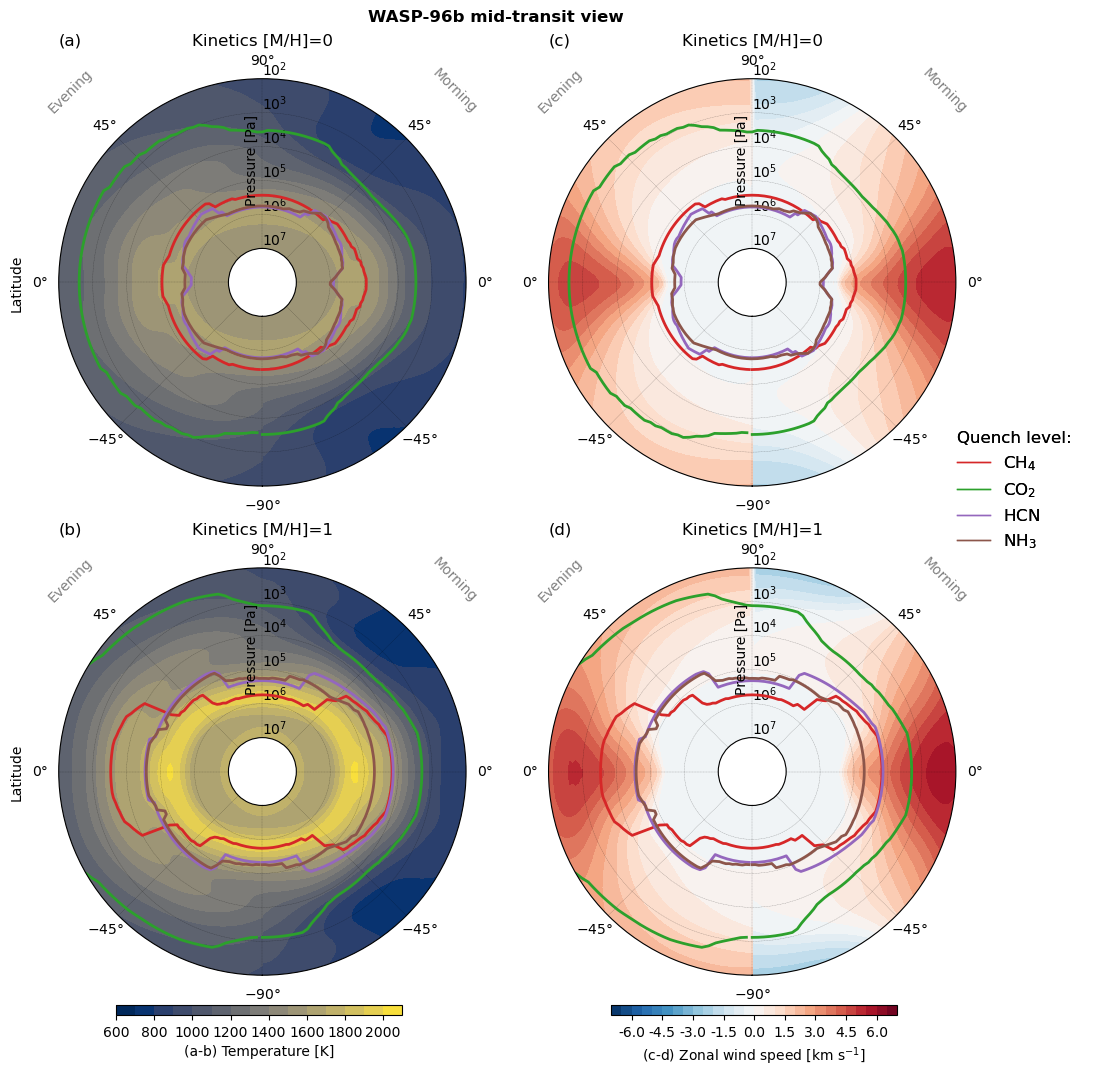

In [14]:
plt_midtransit_w_all_sps_kinetics_only("temp", "u", add_sp_qpts=True)

In [15]:
def plt_midtransit_w_diff(var_name, sp_name, add_sp_qpts=True):
    """Plot variable distribution in the terminator plane from equilibrium and kinetics simulations.
    Plot kinetics minus equilibrium difference.
    Overlay chosen species' quench levels (semi-optional)."""
    fig, ax = plt.subplots(
        nrows=3,
        ncols=3,
        figsize=(12, 12),
        subplot_kw={"projection": "polar"},
        facecolor="w",
        sharex=True,
        sharey=True,
        constrained_layout=True,
    )
    iletters = subplot_label_generator()
    # Quench points (manual)
    sp_qpts_manl = sps_qpts_dlat[sp_name]

    for mdh, axrow in zip(["mdh_0", "mdh_1"], ax[0:2, 0:2]):
        for exp, iax in zip(["equilibrium", "kinetics"], axrow):
            # Get variable
            if var_name == "temp":
                plt_cb = butterfly_terminator(vrbls[exp][mdh]["temp_plevs_mean"])
                levels = np.arange(temp_min, temp_max + 100, 100)
                cmap = "cividis"  # "gist_gray"
                cbar_var_lbl = "Temperature [K]"
                folder = "circulation"
            if var_name == "u":
                plt_cb = butterfly_terminator(vrbls[exp][mdh]["u_plevs_mean"])
                levels = np.arange(
                    -(np.abs([u_min, u_max])).max(), (np.abs([u_min, u_max])).max() + 500, 500
                )
                cmap = "RdBu_r"
                cbar_var_lbl = "Zonal wind [m $s^{-1}$]"
                folder = "circulation"
            if var_name == "v":
                plt_cb = butterfly_terminator(vrbls[exp][mdh]["v_plevs_mean"])
                levels = np.arange(
                    -(np.abs([v_min, v_max])).max(), (np.abs([v_min, v_max])).max() + 200, 200
                )
                cmap = "RdBu_r"
                cbar_var_lbl = "Meridional wind [m $s^{-1}$]"
                folder = "circulation"
            if var_name == "w":
                plt_cb = butterfly_terminator(vrbls[exp][mdh]["w_plevs_mean"])
                levels = np.arange(
                    -(np.abs([w_min, w_max])).max(), (np.abs([w_min, w_max])).max() + 2, 2
                )
                cmap = "RdBu_r"
                cbar_var_lbl = "Vertical wind [m $s^{-1}$]"
                folder = "circulation"
            if var_name in ["ch4", "co2", "hcn", "nh3", "h2o", "co"]:
                plt_cb = butterfly_terminator(
                    vrbls[exp][mdh]["sps_plevs_mean"].extract_cube(
                        f"{var_name.upper()} mole fraction"
                    )
                )
                levels = np.linspace(
                    np.log10(chem_xlims[var_name.upper()]["xmin"]),
                    np.log10(chem_xlims[var_name.upper()]["xmax"]),
                    22,
                )
                cmap = "YlGn"
                cbar_var_lbl = f"{GASES[var_name.upper()]['tex']} mole fraction"
                folder = "chemistry"
            # Transpose variable
            plt_data = plt_cb.data.T
            # Logarithm the data
            if var_name.upper() in chem_names.keys():
                plt_data = np.log10(plt_data)

            # Set coordinates
            r, theta = np.meshgrid(
                np.log10(plt_cb.coord("air_pressure").points),
                np.deg2rad(plt_cb.coord("polar_theta").points),
            )
            # Plot variable
            p0 = iax.contourf(theta, r, plt_data, cmap=cmap, levels=levels, zorder=-20)
            iax.set_rasterization_zorder(-10)

            # Add quench points
            if add_sp_qpts:
                w_sp_qpts = f"_w_{sp_name}_qplevs"
                if exp == "kinetics":
                    plt_sp_qpts_manl = np.log10(sp_qpts_manl[mdh]["sp_qpts_dlat_plevs"])
                    iax.plot(
                        np.deg2rad(np.arange(0, 360, 2)), plt_sp_qpts_manl, ls="solid", color="k"
                    )
            else:
                w_sp_qpts = ""

            # Grid
            iax.set_title(f"({next(iletters)})", loc="left")
            iax.set_title(f"{exp.capitalize()} [M/H]={mdh[-1]}", loc="center")
            iax.set_theta_zero_location("S")
            iax.set_theta_direction("counterclockwise")
            iax.set_rlabel_position(180)
            if iax.get_subplotspec().is_first_col():
                iax.set_ylabel("Latitude", rotation=90, labelpad=25)
            label_position = iax.get_rlabel_position()
            iax.text(
                np.radians(label_position + 5),
                iax.get_rmax() / 1.6,
                "Pressure [Pa]",
                rotation=label_position - 90,
                ha="center",
                va="center",
            )
            iax.text(
                -3 * np.pi / 4, 0, "Evening", rotation=45, ha="center", va="center", color="grey"
            )
            iax.text(
                -5 * np.pi / 4, 0, "Morning", rotation=-45, ha="center", va="center", color="grey"
            )
            iax.tick_params(axis="x", which="major", pad=3)
            iax.set_xticks(iax.get_xticks())
            iax.set_xticklabels(
                ["$-$90°", "$-$45°", "0°", "45°", "90°", "45°", "0°", "$-$45°"], color="k"
            )
            iax.set_rorigin(8)
            iax.set_rlim(bottom=7, top=2)
            iax.set_yticks(np.arange(7, 1, -1))
            iax.set_yticklabels([rf"$10^{{{i}}}$" for i in np.arange(7, 1, -1)], color="k")
            iax.grid(ls="dotted", lw=0.2, color="k")

    # Colorbars
    cax_var = fig.add_axes([2.1 * 1 / 3, 0.22, 1 / 3.5, 0.01])
    cax_var_bar = fig.colorbar(
        p0,
        ax=ax,
        cax=cax_var,
        label="(a-d) " + cbar_var_lbl,
        orientation="horizontal",
        shrink=0.5,
    )
    if var_name in ["ch4", "co2", "hcn", "nh3", "h2o", "co"]:
        cax_var_bar.set_ticks(cax_var.get_xticks())
        cax_var_bar.set_ticklabels([latex_power(i) for i in cax_var.get_xticks()])

    # Variable difference
    if var_name in ["temp"]:  # "u", "v", "w"]:
        plt_var_equ_mdh_0 = butterfly_terminator(
            vrbls["equilibrium"]["mdh_0"][f"{var_name}_plevs_mean"]
        ).data.T
        plt_var_kin_mdh_0 = butterfly_terminator(
            vrbls["kinetics"]["mdh_0"][f"{var_name}_plevs_mean"]
        ).data.T
        plt_var_equ_mdh_1 = butterfly_terminator(
            vrbls["equilibrium"]["mdh_1"][f"{var_name}_plevs_mean"]
        ).data.T
        plt_var_kin_mdh_1 = butterfly_terminator(
            vrbls["kinetics"]["mdh_1"][f"{var_name}_plevs_mean"]
        ).data.T
        # temp only
        diff_cf_kws = {
            "levels": np.arange(-400, 450, 50),
            "cmap": "RdBu_r",
        }
        cbar_diff_lbl = "Temperature difference [K]"
    if var_name in ["ch4", "co2", "hcn", "nh3", "h2o", "co"]:
        plt_var_equ_mdh_0 = butterfly_terminator(
            vrbls["equilibrium"]["mdh_0"]["sps_plevs_mean"].extract_cube(
                f"{var_name.upper()} mole fraction"
            )
        ).data.T
        plt_var_kin_mdh_0 = butterfly_terminator(
            vrbls["kinetics"]["mdh_0"]["sps_plevs_mean"].extract_cube(
                f"{var_name.upper()} mole fraction"
            )
        ).data.T
        plt_var_equ_mdh_1 = butterfly_terminator(
            vrbls["equilibrium"]["mdh_1"]["sps_plevs_mean"].extract_cube(
                f"{var_name.upper()} mole fraction"
            )
        ).data.T
        plt_var_kin_mdh_1 = butterfly_terminator(
            vrbls["kinetics"]["mdh_1"]["sps_plevs_mean"].extract_cube(
                f"{var_name.upper()} mole fraction"
            )
        ).data.T
        diff_cf_kws = {
            "norm": colors.SymLogNorm(linthresh=1e-12, vmin=-1e-2, vmax=1e-2),
            "levels": np.concatenate([-np.logspace(-12, -2, 11)[::-1], np.logspace(-12, -2, 11)]),
            "cmap": "RdBu_r",
        }
        cbar_diff_lbl = cbar_var_lbl + " difference"

    plt_var_equ_mdh_1_m_equ_mdh_0 = plt_var_equ_mdh_1 - plt_var_equ_mdh_0
    plt_var_kin_mdh_1_m_kin_mdh_0 = plt_var_kin_mdh_1 - plt_var_kin_mdh_0
    plt_var_kin_mdh_0_m_equ_mdh_0 = plt_var_kin_mdh_0 - plt_var_equ_mdh_0
    plt_var_kin_mdh_1_m_equ_mdh_1 = plt_var_kin_mdh_1 - plt_var_equ_mdh_1

    pdiff = ax[0, 2].contourf(theta, r, plt_var_kin_mdh_0_m_equ_mdh_0, **diff_cf_kws, zorder=-20)
    ax[1, 2].contourf(theta, r, plt_var_kin_mdh_1_m_equ_mdh_1, **diff_cf_kws, zorder=-20)
    ax[2, 0].contourf(theta, r, plt_var_equ_mdh_1_m_equ_mdh_0, **diff_cf_kws, zorder=-20)
    ax[2, 1].contourf(theta, r, plt_var_kin_mdh_1_m_kin_mdh_0, **diff_cf_kws, zorder=-20)
    ax[2, 2].axis("off")
    ax[0, 2].set_title("(g)", loc="left")
    ax[1, 2].set_title("(h)", loc="left")
    ax[2, 0].set_title("(e)", loc="left")
    ax[2, 1].set_title("(f)", loc="left")
    ax[0, 2].set_title(f"Kin [M/H]=0 - Equ [M/H]=0", loc="center")
    ax[1, 2].set_title(f"Kin [M/H]=1 - Equ [M/H]=1", loc="center")
    ax[2, 0].set_title(f"Equ [M/H]=1 - Equ [M/H]=0", loc="center")
    ax[2, 1].set_title(f"Kin [M/H]=1 - Kin [M/H]=0", loc="center")
    ax[0, 2].set_rasterization_zorder(-10)
    ax[1, 2].set_rasterization_zorder(-10)
    ax[2, 0].set_rasterization_zorder(-10)
    ax[2, 1].set_rasterization_zorder(-10)

    # Grid
    for jax in ax.flatten()[:-1]:
        jax.set_theta_zero_location("S")
        jax.set_theta_direction("counterclockwise")
        jax.set_rlabel_position(180)
        label_position = jax.get_rlabel_position()
        jax.text(
            np.radians(label_position + 5),
            jax.get_rmax() / 1.6,
            "Pressure [Pa]",
            rotation=label_position - 90,
            ha="center",
            va="center",
        )
        jax.text(-3 * np.pi / 4, 0, "Evening", rotation=45, ha="center", va="center", color="grey")
        jax.text(-5 * np.pi / 4, 0, "Morning", rotation=-45, ha="center", va="center", color="grey")
        jax.tick_params(axis="x", which="major", pad=3)
        jax.set_xticks(iax.get_xticks())
        jax.set_xticklabels(
            ["$-$90°", "$-$45°", "0°", "45°", "90°", "45°", "0°", "$-$45°"], color="k"
        )
        jax.set_rorigin(8)
        jax.set_rlim(bottom=7, top=2)
        jax.set_yticks(np.arange(7, 1, -1))
        jax.set_yticklabels([rf"$10^{{{i}}}$" for i in np.arange(7, 1, -1)], color="k")
        jax.grid(ls="dotted", lw=0.2, color="k")

    # Colorbar difference
    cax_diff = fig.add_axes([2.1 * 1 / 3, 0.15, 1 / 3.5, 0.01])
    cax_diff_bar = fig.colorbar(
        pdiff,
        ax=ax,
        cax=cax_diff,
        label="(e-h) " + cbar_diff_lbl,
        orientation="horizontal",
        shrink=0.5,
    )
    if var_name in ["ch4", "co2", "hcn", "nh3", "h2o", "co"]:
        cax_diff_bar.set_ticks(
            np.concatenate([-np.logspace(-12, -2, 11)[::-1], np.logspace(-12, -2, 11)])[::3]
        )
        cax_diff_bar.set_ticklabels(
            [
                latex_symlog(i)
                for i in np.concatenate(
                    [-np.logspace(-12, -2, 11)[::-1], np.logspace(-12, -2, 11)]
                )[::3]
            ]
        )
    fig.suptitle(f"{PLANETS[planet]['tex']} mid-transit view", weight="bold")
    figname_png = f"{planet}_midtransit_{var_name}{w_sp_qpts}_w_diff.png"
    figname_pdf = f"{planet}_midtransit_{var_name}{w_sp_qpts}_w_diff.pdf"
    fig.savefig(
        path_to_project / folder / "cross_section_terminator" / figname_png, bbox_inches="tight"
    )
    fig.savefig(
        path_to_project / folder / "cross_section_terminator" / figname_pdf,
        bbox_inches="tight",
        format="pdf",
    );

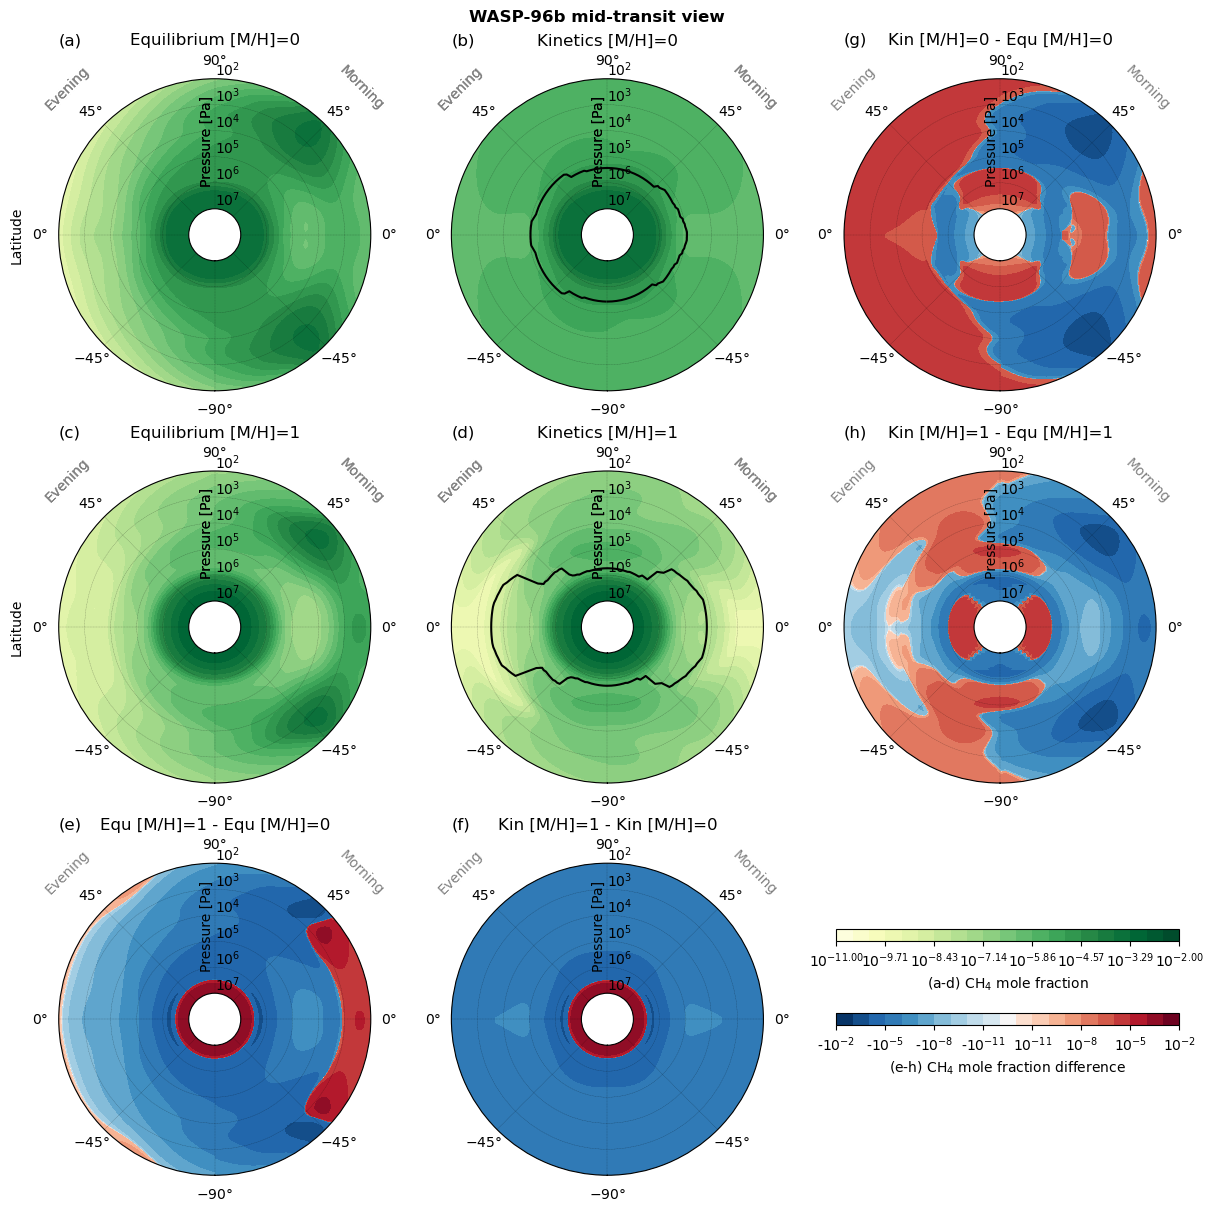

In [16]:
plt_midtransit_w_diff("ch4", "ch4", add_sp_qpts=True)

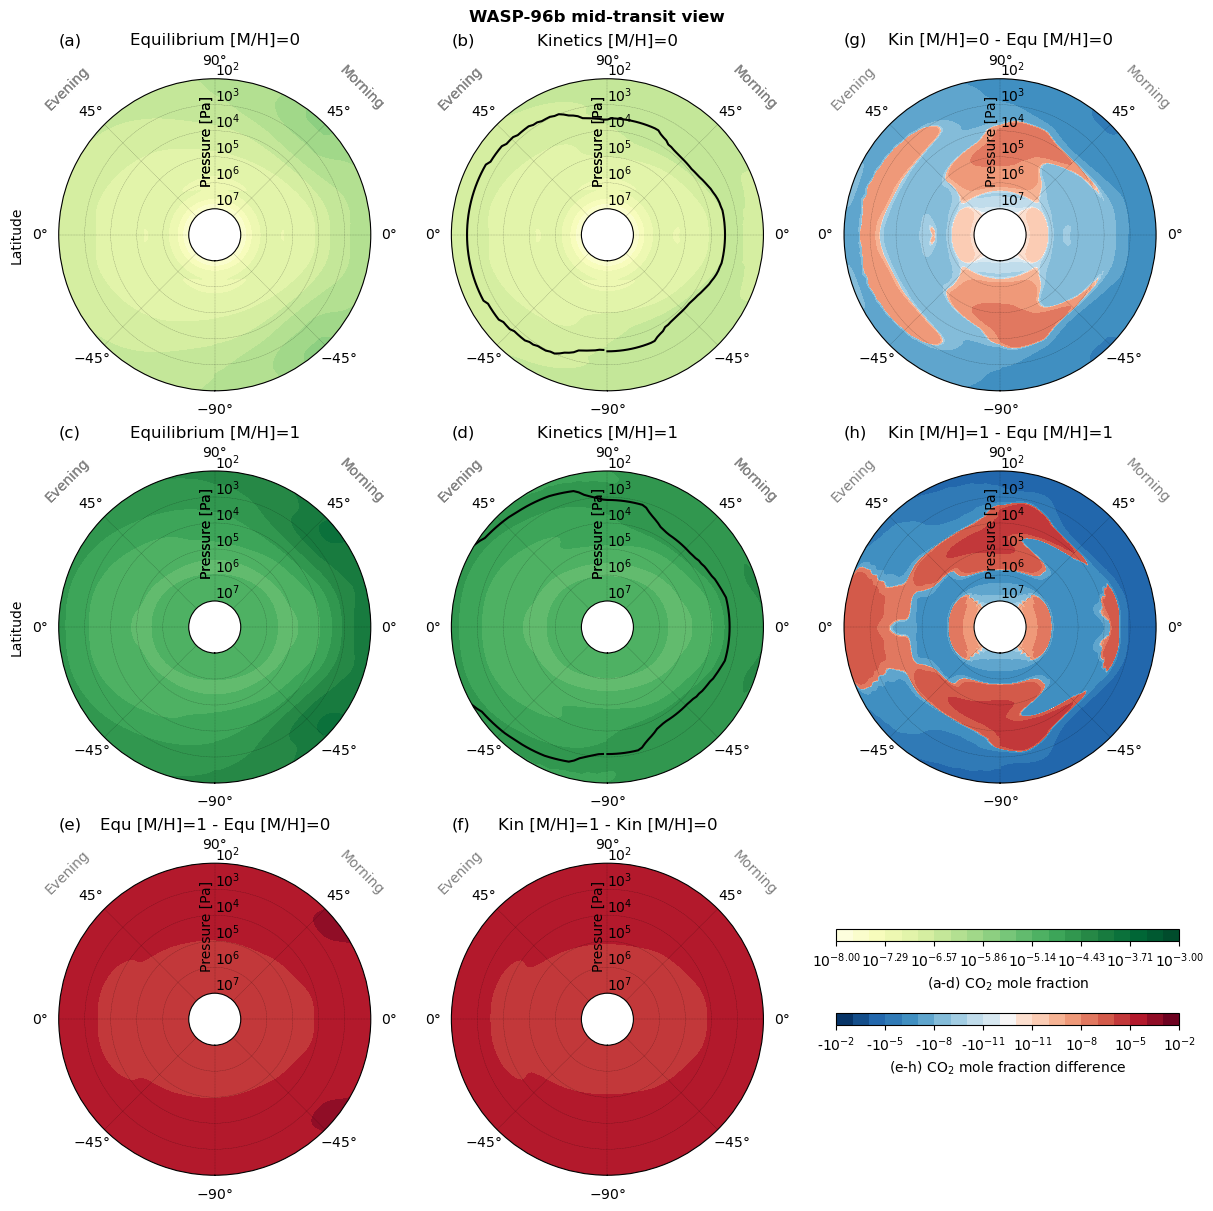

In [17]:
plt_midtransit_w_diff("co2", "co2", add_sp_qpts=True)

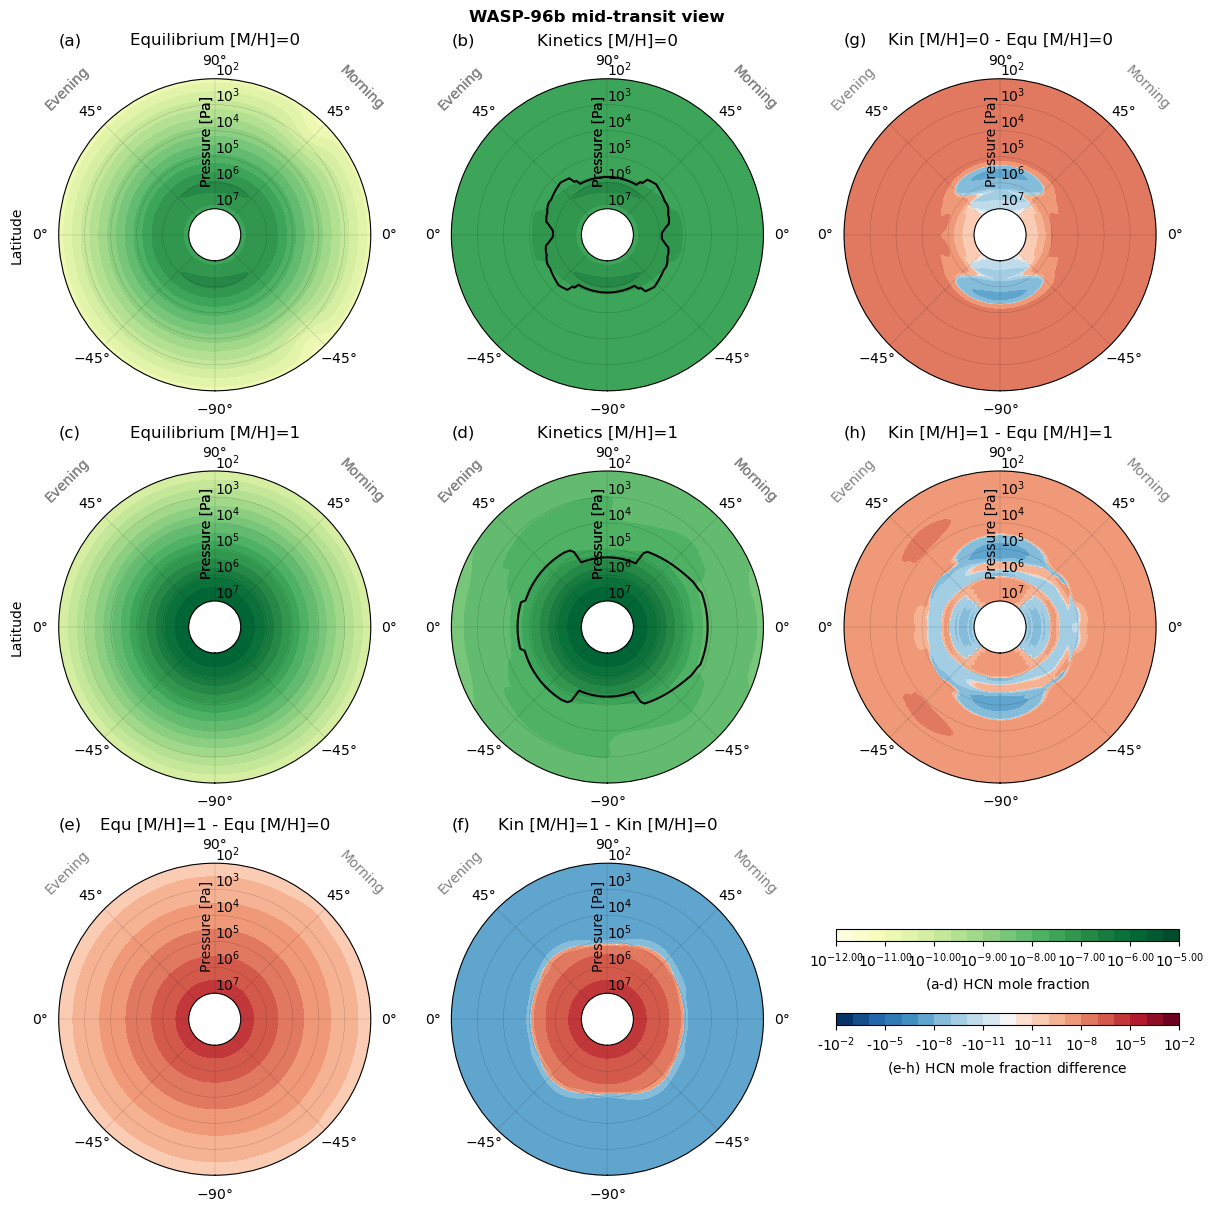

In [18]:
plt_midtransit_w_diff("hcn", "hcn", add_sp_qpts=True)

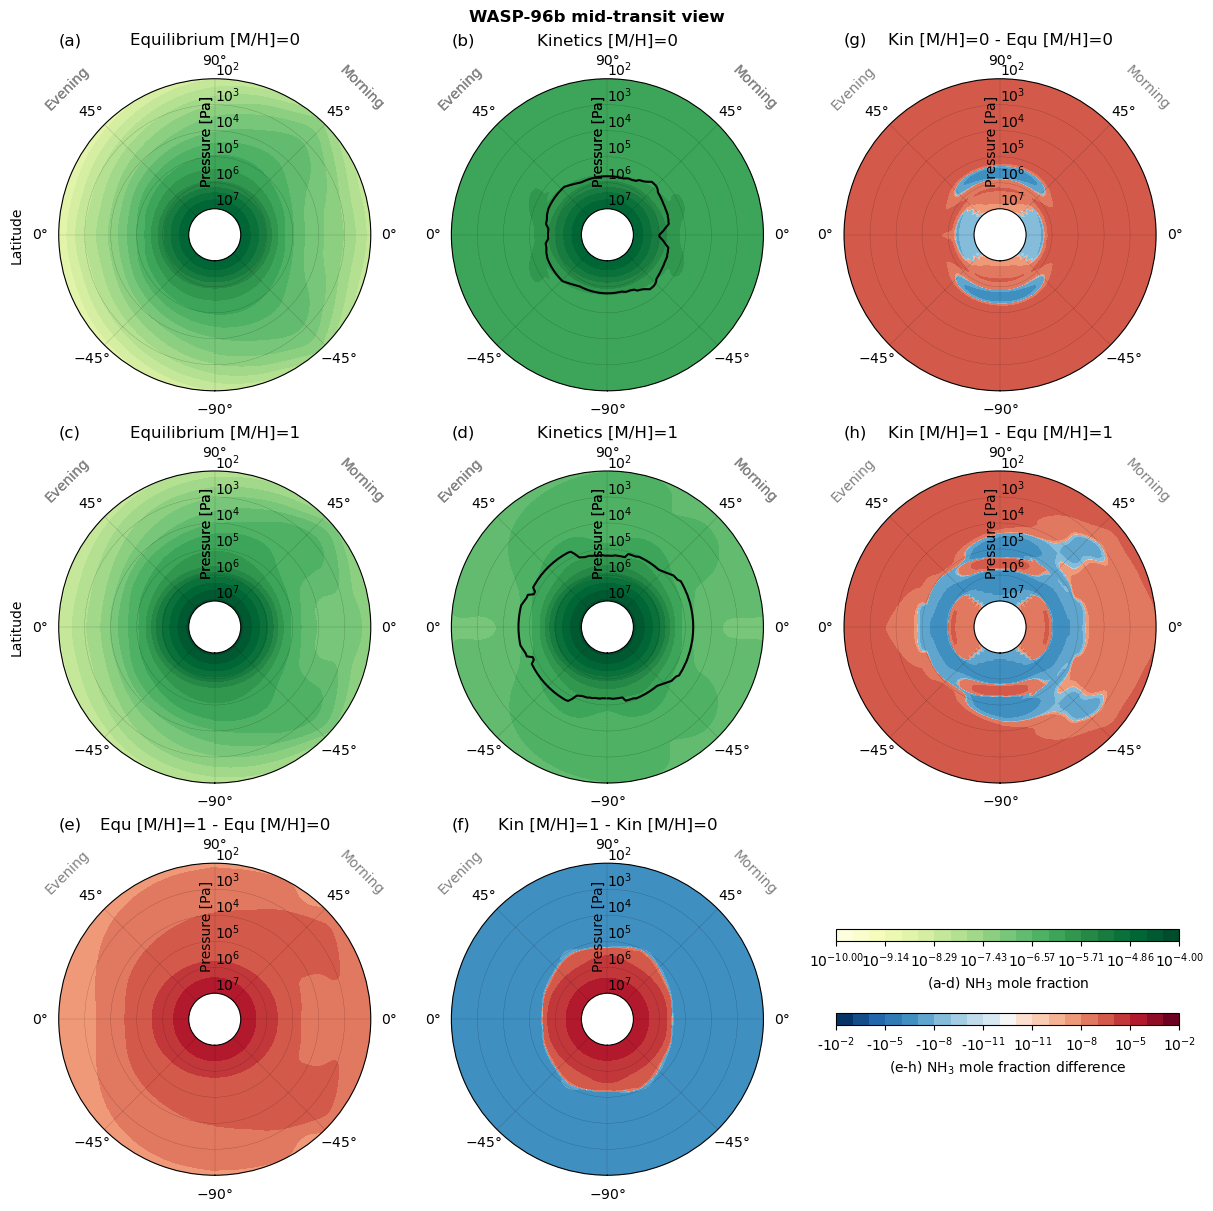

In [19]:
plt_midtransit_w_diff("nh3", "nh3", add_sp_qpts=True)

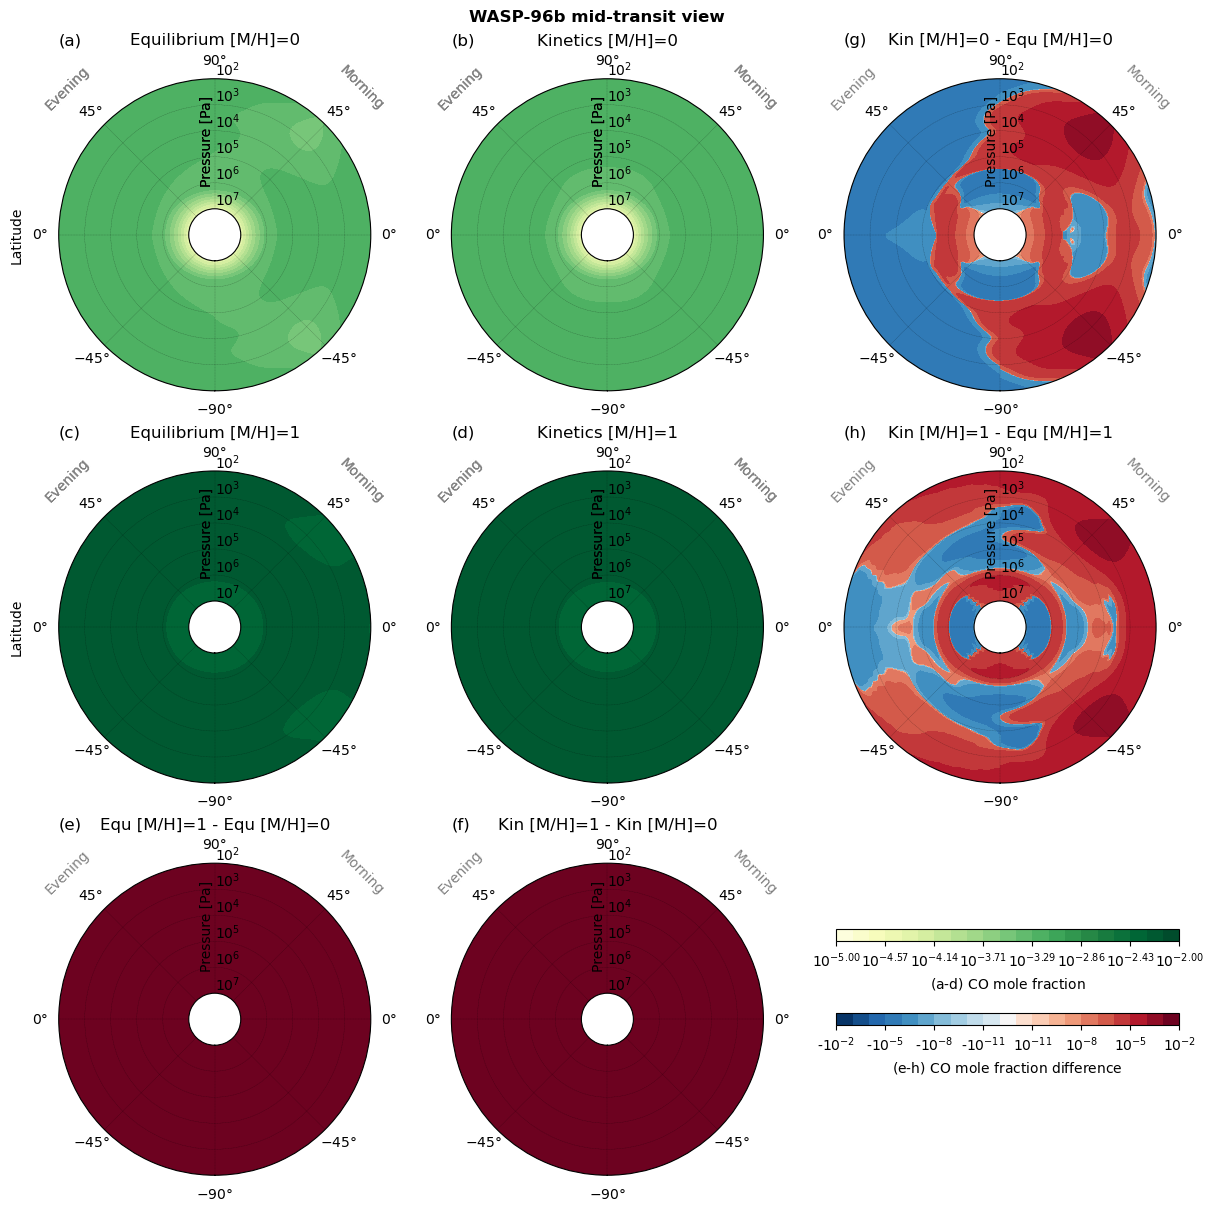

In [20]:
plt_midtransit_w_diff("co", "ch4", add_sp_qpts=False)

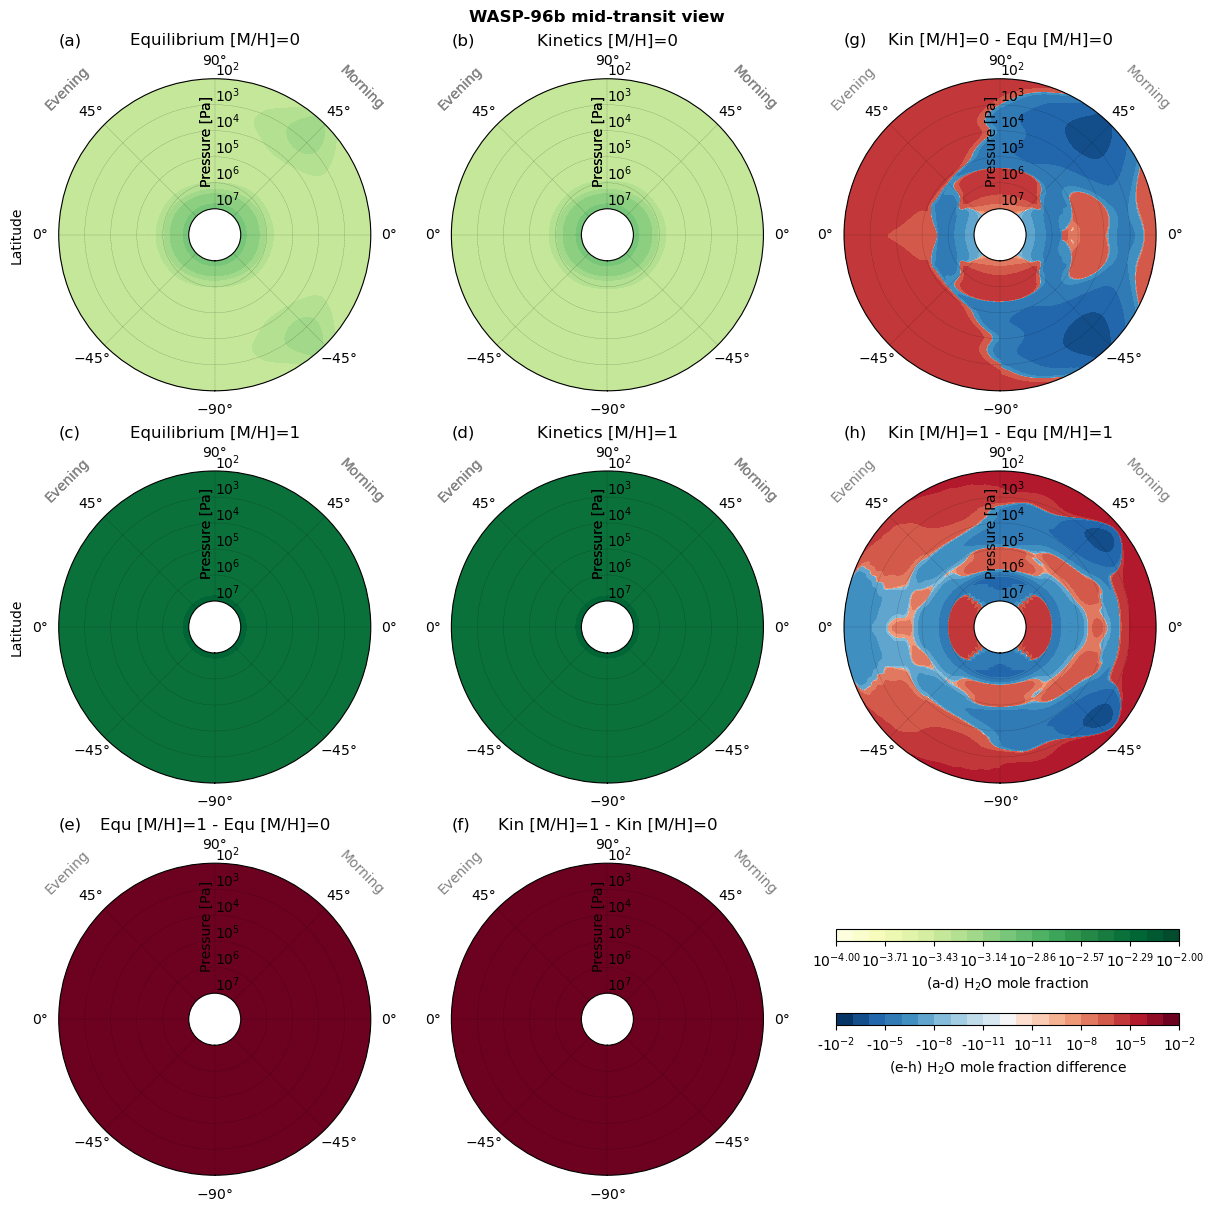

In [21]:
plt_midtransit_w_diff("h2o", "ch4", add_sp_qpts=False)

In [22]:
def plt_midtransit_w_diff_w_all_sps(var_name, add_sp_qpts=True):
    """Plot variable distribution in the terminator plane from equilibrium and kinetics simulations.
    Plot kinetics minus equilibrium difference.
    Overlay all species' quench levels (optional)."""
    fig, ax = plt.subplots(
        nrows=3,
        ncols=3,
        figsize=(12, 12),
        subplot_kw={"projection": "polar"},
        facecolor="w",
        sharex=True,
        sharey=True,
        constrained_layout=True,
    )
    iletters = subplot_label_generator()
    # Quench points
    sp_qpts = sps_qpts_dlat

    for mdh, axrow in zip(["mdh_0", "mdh_1"], ax[0:2, 0:2]):
        for exp, iax in zip(["equilibrium", "kinetics"], axrow):
            # Get variable
            if var_name == "temp":
                plt_cb = butterfly_terminator(vrbls[exp][mdh]["temp_plevs_mean"])
                levels = np.arange(temp_min, temp_max + 100, 100)
                cmap = "cividis"  # "gist_gray"
                cbar_var_lbl = "Temperature [K]"
                folder = "circulation"
            if var_name == "u":
                plt_cb = butterfly_terminator(vrbls[exp][mdh]["u_plevs_mean"])
                levels = np.arange(
                    -(np.abs([u_min, u_max])).max(), (np.abs([u_min, u_max])).max() + 500, 500
                )
                cmap = "RdBu_r"
                cbar_var_lbl = "Zonal wind speed [m $s^{-1}$]"
                folder = "circulation"
            if var_name == "v":
                plt_cb = butterfly_terminator(vrbls[exp][mdh]["v_plevs_mean"])
                levels = np.arange(
                    -(np.abs([v_min, v_max])).max(), (np.abs([v_min, v_max])).max() + 200, 200
                )
                cmap = "RdBu_r"
                cbar_var_lbl = "Meridional wind speed [m $s^{-1}$]"
                folder = "circulation"
            if var_name == "w":
                plt_cb = butterfly_terminator(vrbls[exp][mdh]["w_plevs_mean"])
                levels = np.arange(
                    -(np.abs([w_min, w_max])).max(), (np.abs([w_min, w_max])).max() + 2, 2
                )
                cmap = "RdBu_r"
                cbar_var_lbl = "Vertical wind speed [m $s^{-1}$]"
                folder = "circulation"
            if var_name in ["ch4", "co2", "hcn", "nh3"]:
                plt_cb = butterfly_terminator(
                    vrbls[exp][mdh]["sps_plevs_mean"].extract_cube(
                        f"{var_name.upper()} mole fraction"
                    )
                )
                levels = np.linspace(
                    np.log10(chem_xlims[var_name.upper()]["xmin"]),
                    np.log10(chem_xlims[var_name.upper()]["xmax"]),
                    22,
                )
                cmap = "YlGn"
                cbar_var_lbl = f"{GASES[var_name.upper()]['tex']} mole fraction"
                folder = "chemistry"
            # Transpose variable
            plt_data = plt_cb.data.T
            # Logarithm the data
            if var_name.upper() in chem_names.keys():
                plt_data = np.log10(plt_data)

            # Set coordinates
            r, theta = np.meshgrid(
                np.log10(plt_cb.coord("air_pressure").points),
                np.deg2rad(plt_cb.coord("polar_theta").points),
            )
            # Plot variable
            p0 = iax.contourf(theta, r, plt_data, cmap=cmap, levels=levels, zorder=-20)
            iax.set_rasterization_zorder(-10)

            # Add quench points
            if add_sp_qpts:
                w_sp_qpts = f"_w_all_sps_qplevs"
                if exp == "kinetics":
                    for sp, sp_clr in zip(sp_qpts.keys(), ["C3", "C1", "C4", "C5"]):
                        plt_sp_qpts = np.log10(sp_qpts[sp][mdh]["sp_qpts_dlat_plevs"])
                        iax.plot(
                            np.deg2rad(np.arange(0, 360, 2)), plt_sp_qpts, ls="solid", color=sp_clr
                        )
            else:
                w_sp_qpts = ""

            # Grid
            iax.set_title(f"({next(iletters)})", loc="left")
            iax.set_title(f"{exp.capitalize()} [M/H]={mdh[-1]}", loc="center")
            iax.set_theta_zero_location("S")
            iax.set_theta_direction("counterclockwise")
            iax.set_rlabel_position(180)
            if iax.get_subplotspec().is_first_col():
                iax.set_ylabel("Latitude", rotation=90, labelpad=25)
            label_position = iax.get_rlabel_position()
            iax.text(
                np.radians(label_position + 5),
                iax.get_rmax() / 1.6,
                "Pressure [Pa]",
                rotation=label_position - 90,
                ha="center",
                va="center",
            )
            iax.text(
                -3 * np.pi / 4, 0, "Evening", rotation=45, ha="center", va="center", color="grey"
            )
            iax.text(
                -5 * np.pi / 4, 0, "Morning", rotation=-45, ha="center", va="center", color="grey"
            )
            iax.tick_params(axis="x", which="major", pad=3)
            iax.set_xticks(iax.get_xticks())
            iax.set_xticklabels(
                ["$-$90°", "$-$45°", "0°", "45°", "90°", "45°", "0°", "$-$45°"], color="k"
            )
            iax.set_rorigin(8)
            iax.set_rlim(bottom=7, top=2)
            iax.set_yticks(np.arange(7, 1, -1))
            iax.set_yticklabels([rf"$10^{{{i}}}$" for i in np.arange(7, 1, -1)], color="k")
            iax.grid(ls="dotted", lw=0.2, color="k")

    # Colorbar
    cax_var = fig.add_axes([2.1 * 1 / 3, 0.22, 1 / 3.5, 0.01])
    cax_var_bar = fig.colorbar(
        p0,
        ax=ax,
        cax=cax_var,
        label="(a-d) " + cbar_var_lbl,
        orientation="horizontal",
        shrink=0.5,
    )
    if var_name in ["ch4", "co2", "hcn", "nh3"]:
        cax_var_bar.set_ticks(cax_var.get_xticks())
        cax_var_bar.set_ticklabels([latex_power(i) for i in cax_var.get_xticks()])

    # Variable difference
    if var_name in ["temp"]:
        plt_var_equ_mdh_0 = butterfly_terminator(
            vrbls["equilibrium"]["mdh_0"][f"{var_name}_plevs_mean"]
        ).data.T
        plt_var_kin_mdh_0 = butterfly_terminator(
            vrbls["kinetics"]["mdh_0"][f"{var_name}_plevs_mean"]
        ).data.T
        plt_var_equ_mdh_1 = butterfly_terminator(
            vrbls["equilibrium"]["mdh_1"][f"{var_name}_plevs_mean"]
        ).data.T
        plt_var_kin_mdh_1 = butterfly_terminator(
            vrbls["kinetics"]["mdh_1"][f"{var_name}_plevs_mean"]
        ).data.T
        diff_cf_kws = {
            "levels": np.arange(-400, 450, 50),
            "cmap": "RdBu_r",
        }
        cbar_diff_lbl = "Temperature difference [K]"
    if var_name in ["u"]:  # "v", "w"
        plt_var_equ_mdh_0 = butterfly_terminator(
            vrbls["equilibrium"]["mdh_0"][f"{var_name}_plevs_mean"]
        ).data.T
        plt_var_kin_mdh_0 = butterfly_terminator(
            vrbls["kinetics"]["mdh_0"][f"{var_name}_plevs_mean"]
        ).data.T
        plt_var_equ_mdh_1 = butterfly_terminator(
            vrbls["equilibrium"]["mdh_1"][f"{var_name}_plevs_mean"]
        ).data.T
        plt_var_kin_mdh_1 = butterfly_terminator(
            vrbls["kinetics"]["mdh_1"][f"{var_name}_plevs_mean"]
        ).data.T
        diff_cf_kws = {
            "levels": np.arange(-2500, 3000, 500),
            "cmap": "RdBu_r",
        }
        cbar_diff_lbl = "Zonal wind speed difference [m $s^{-1}$]"
    if var_name in ["ch4", "co2", "hcn", "nh3"]:
        plt_var_equ_mdh_0 = butterfly_terminator(
            vrbls["equilibrium"]["mdh_0"]["sps_plevs_mean"].extract_cube(
                f"{var_name.upper()} mole fraction"
            )
        ).data.T
        plt_var_kin_mdh_0 = butterfly_terminator(
            vrbls["kinetics"]["mdh_0"]["sps_plevs_mean"].extract_cube(
                f"{var_name.upper()} mole fraction"
            )
        ).data.T
        plt_var_equ_mdh_1 = butterfly_terminator(
            vrbls["equilibrium"]["mdh_1"]["sps_plevs_mean"].extract_cube(
                f"{var_name.upper()} mole fraction"
            )
        ).data.T
        plt_var_kin_mdh_1 = butterfly_terminator(
            vrbls["kinetics"]["mdh_1"]["sps_plevs_mean"].extract_cube(
                f"{var_name.upper()} mole fraction"
            )
        ).data.T

        diff_cf_kws = {
            "norm": colors.SymLogNorm(linthresh=1e-12, vmin=-1e-2, vmax=1e-2),
            "levels": np.concatenate([-np.logspace(-12, -2, 11)[::-1], np.logspace(-12, -2, 11)]),
            "cmap": "RdBu_r",
        }
        cbar_diff_lbl = cbar_var_lbl + " difference"

    plt_var_equ_mdh_1_m_equ_mdh_0 = plt_var_equ_mdh_1 - plt_var_equ_mdh_0
    plt_var_kin_mdh_1_m_kin_mdh_0 = plt_var_kin_mdh_1 - plt_var_kin_mdh_0
    plt_var_kin_mdh_0_m_equ_mdh_0 = plt_var_kin_mdh_0 - plt_var_equ_mdh_0
    plt_var_kin_mdh_1_m_equ_mdh_1 = plt_var_kin_mdh_1 - plt_var_equ_mdh_1

    pdiff = ax[0, 2].contourf(theta, r, plt_var_kin_mdh_0_m_equ_mdh_0, **diff_cf_kws, zorder=-20)
    ax[1, 2].contourf(theta, r, plt_var_kin_mdh_1_m_equ_mdh_1, **diff_cf_kws, zorder=-20)
    ax[2, 0].contourf(theta, r, plt_var_equ_mdh_1_m_equ_mdh_0, **diff_cf_kws, zorder=-20)
    ax[2, 1].contourf(theta, r, plt_var_kin_mdh_1_m_kin_mdh_0, **diff_cf_kws, zorder=-20)
    ax[2, 2].axis("off")
    ax[0, 2].set_title("(g)", loc="left")
    ax[1, 2].set_title("(h)", loc="left")
    ax[2, 0].set_title("(e)", loc="left")
    ax[2, 1].set_title("(f)", loc="left")
    ax[0, 2].set_title(f"Kin [M/H]=0 - Equ [M/H]=0", loc="center")
    ax[1, 2].set_title(f"Kin [M/H]=1 - Equ [M/H]=1", loc="center")
    ax[2, 0].set_title(f"Equ [M/H]=1 - Equ [M/H]=0", loc="center")
    ax[2, 1].set_title(f"Kin [M/H]=1 - Kin [M/H]=0", loc="center")
    ax[0, 2].set_rasterization_zorder(-10)
    ax[1, 2].set_rasterization_zorder(-10)
    ax[2, 0].set_rasterization_zorder(-10)
    ax[2, 1].set_rasterization_zorder(-10)

    # Grid
    for jax in ax.flatten()[:-1]:
        jax.set_theta_zero_location("S")
        jax.set_theta_direction("counterclockwise")
        jax.set_rlabel_position(180)
        label_position = jax.get_rlabel_position()
        jax.text(
            np.radians(label_position + 5),
            jax.get_rmax() / 1.6,
            "Pressure [Pa]",
            rotation=label_position - 90,
            ha="center",
            va="center",
        )
        jax.text(-3 * np.pi / 4, 0, "Evening", rotation=45, ha="center", va="center", color="grey")
        jax.text(-5 * np.pi / 4, 0, "Morning", rotation=-45, ha="center", va="center", color="grey")
        jax.tick_params(axis="x", which="major", pad=3)
        jax.set_xticks(iax.get_xticks())
        jax.set_xticklabels(
            ["$-$90°", "$-$45°", "0°", "45°", "90°", "45°", "0°", "$-$45°"], color="k"
        )
        jax.set_rorigin(8)
        jax.set_rlim(bottom=7, top=2)
        jax.set_yticks(np.arange(7, 1, -1))
        jax.set_yticklabels([rf"$10^{{{i}}}$" for i in np.arange(7, 1, -1)], color="k")
        jax.grid(ls="dotted", lw=0.2, color="k")

    # Colorbar difference
    cax_diff = fig.add_axes([2.1 * 1 / 3, 0.15, 1 / 3.5, 0.01])
    cax_diff_bar = fig.colorbar(
        pdiff,
        ax=ax,
        cax=cax_diff,
        label="(e-h) " + cbar_diff_lbl,
        orientation="horizontal",
        shrink=0.5,
    )
    if var_name in ["ch4", "co2", "hcn", "nh3"]:
        cax_diff_bar.set_ticks(
            np.concatenate([-np.logspace(-12, -2, 11)[::-1], np.logspace(-12, -2, 11)])[::3]
        )
        cax_diff_bar.set_ticklabels(
            [
                latex_symlog(i)
                for i in np.concatenate(
                    [-np.logspace(-12, -2, 11)[::-1], np.logspace(-12, -2, 11)]
                )[::3]
            ]
        )
    fig.suptitle(f"{PLANETS[planet]['tex']} mid-transit view", weight="bold")
    figname_png = f"{planet}_midtransit_{var_name}{w_sp_qpts}_w_diff.png"
    figname_pdf = f"{planet}_midtransit_{var_name}{w_sp_qpts}_w_diff.pdf"
    fig.savefig(
        path_to_project / folder / "cross_section_terminator" / figname_png, bbox_inches="tight"
    )
    fig.savefig(
        path_to_project / folder / "cross_section_terminator" / figname_pdf,
        bbox_inches="tight",
        format="pdf",
    );

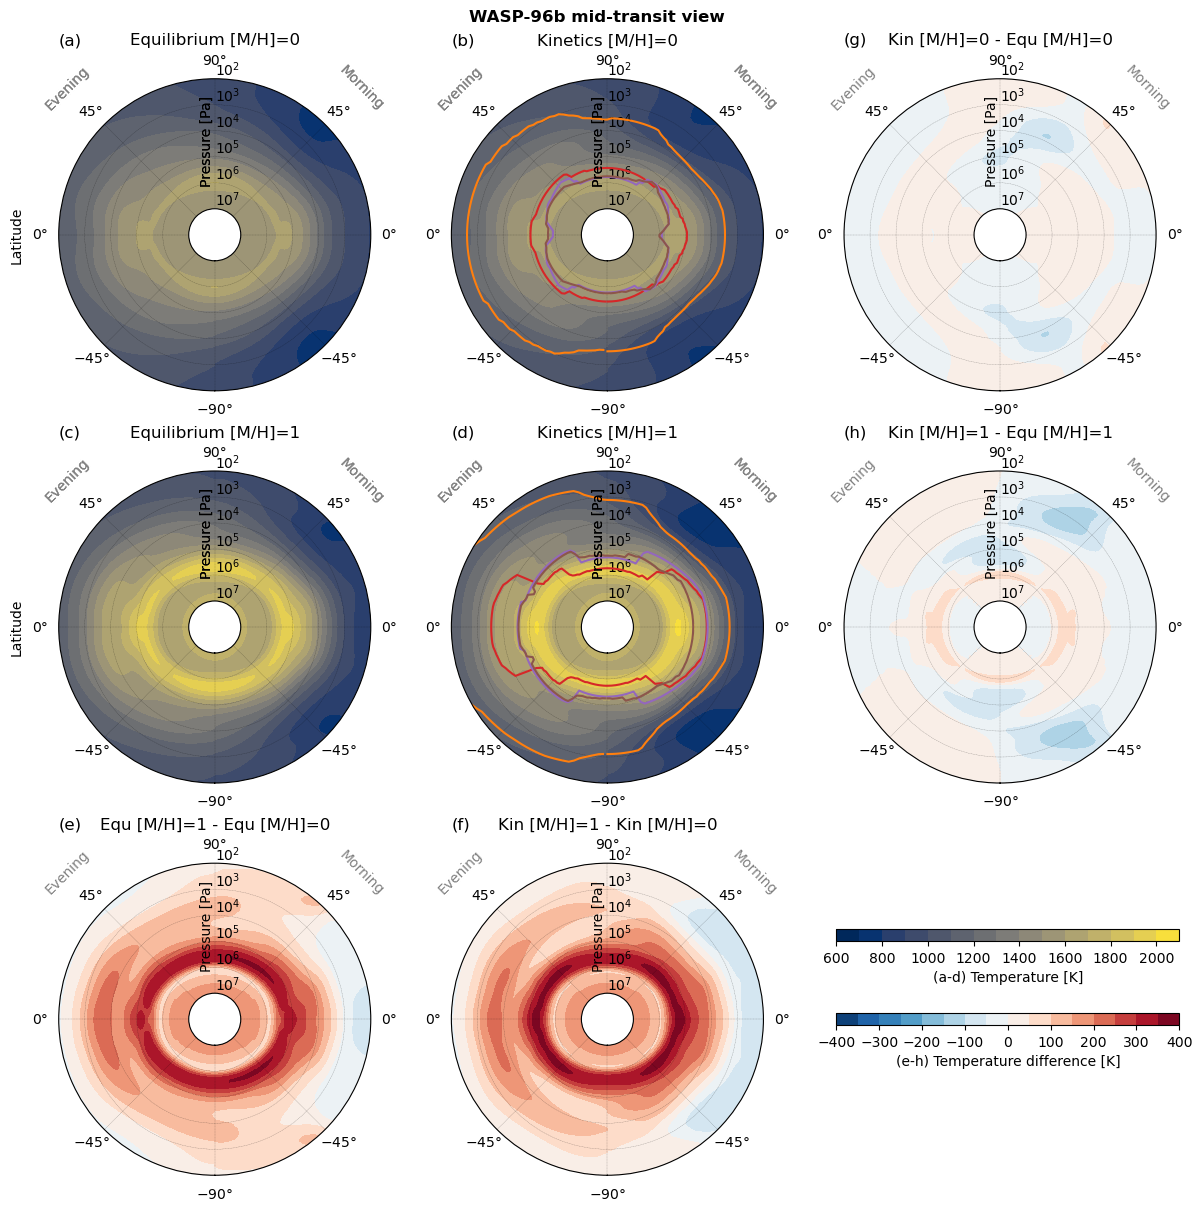

In [23]:
plt_midtransit_w_diff_w_all_sps("temp", add_sp_qpts=True)

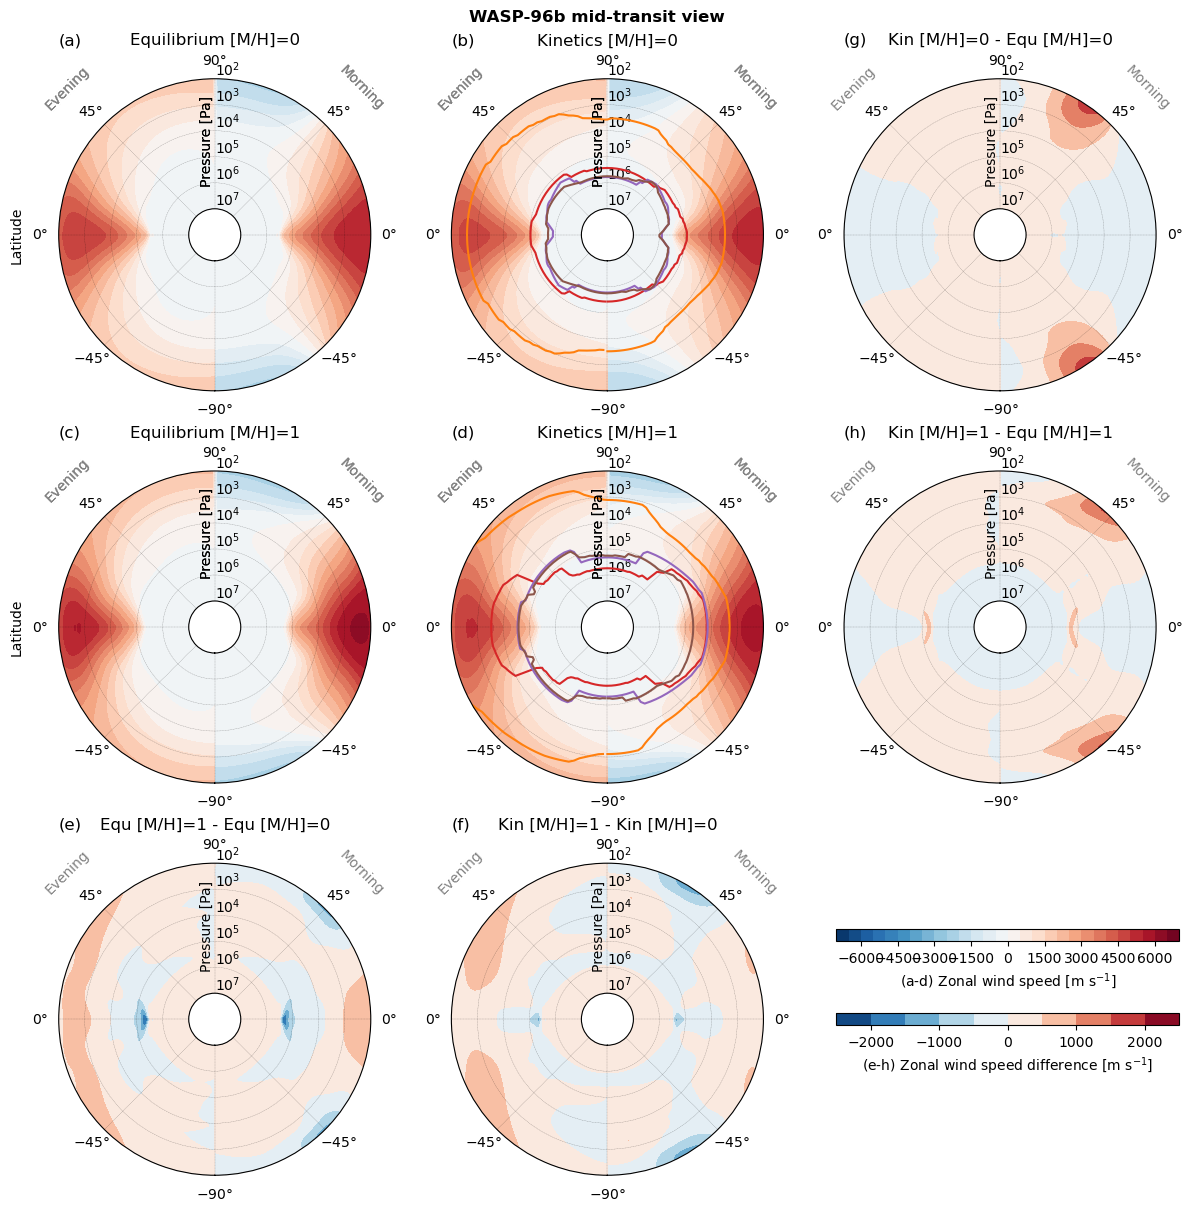

In [24]:
plt_midtransit_w_diff_w_all_sps("u", add_sp_qpts=True)